<a href="https://colab.research.google.com/github/Esteves31/Neural_Networks/blob/main/Projeto01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1 - Supervisionado

---

Nome: Matheus Ramos Esteves                      
R.A: 156.732

## Classificação e Regressão

  <div style="text-align: justify; font-size: 15px;">
  Neste projeto serão apresentados dois dois datasets: íris e uma função que irá gerar dados aleatórios, com o objetivo de relizar uma classificação e uma regressão. Serão considerados alguns pontos como a utilização de diferentes número de camadas, o impacto do uso do Momentum, avaliação do impacto do uso da regularização e a ilustração gráfica da evolução do treinamento/validação. Por fim, no final deste caderno haverá o relatório contendo explicações e a conclusão do experimento.
  </div>


# Classificação

## Pacotes

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

## Importação da Base de Dados

In [ ]:
dataBase = sklearn.datasets.load_iris()
print("Atributos:",dataBase['feature_names'])
print("Classes (labels):",dataBase['target_names'])
print("Dimensões:", dataBase['data'].shape)

df = pd.DataFrame(dataBase.data, columns = dataBase.feature_names)
df['label'] = [dataBase.target_names[i] for i in dataBase.target]

Atributos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes (labels): ['setosa' 'versicolor' 'virginica']
Dimensões: (150, 4)


## Processamento dos dados

In [ ]:
X = df.drop(['label'], axis = 1)
normalizer = MinMaxScaler()
X_norm = pd.DataFrame(normalizer.fit_transform(X), columns = X.columns)
labels = df.label.unique()
print(labels, end = "\n\n")

Y = pd.get_dummies(df.label)
print(Y)

['setosa' 'versicolor' 'virginica']

     setosa  versicolor  virginica
0         1           0          0
1         1           0          0
2         1           0          0
3         1           0          0
4         1           0          0
..      ...         ...        ...
145       0           0          1
146       0           0          1
147       0           0          1
148       0           0          1
149       0           0          1

[150 rows x 3 columns]


## Separação para Treino / Validação / Teste

In [ ]:
X_develop, X_test, Y_develop, Y_test = train_test_split(X_norm, Y, test_size = 0.1, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_develop, Y_develop, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(108, 4)
(27, 4)
(15, 4)


## Modelo 1

### Modelo de Treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim, 10),
        nn.Tanh(),
        nn.Linear(10, output_dim),
        nn.Sigmoid(),
    )

  def forward(self, x):
    out =  self.rede(x)
    return out

### Instanciando o Modelo

In [ ]:
input_dim = 4
output_dim = 3

model = MLP(input_dim, output_dim)

print(model, end = "\n\n")
summary(model, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3               [-1, 150, 3]              33
           Sigmoid-4               [-1, 150, 3]               0
Total params: 83
Trainable params: 83
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.2
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = eta)

### Treinamento da Rede

### Transformação dos Dados em Tensores Pytorch


In [ ]:
x_train = torch.FloatTensor(X_train.values)
y_train = torch.FloatTensor(Y_train.values)

x_val = torch.FloatTensor(X_val.values)
y_val = torch.FloatTensor(Y_val.values)

x_test = torch.FloatTensor(X_val.values)
y_test = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_lossess):
  for epoch in range(num_epochs):
    optimizer.zero_grad()

    output_train = model(x_train)

    loss_train = loss_function(output_train, y_train)

    loss_train.backward()

    optimizer.step()

    output_val = model(x_val)
    loss_val = loss_function(output_val, y_val)

    train_losses[epoch] = loss_train.item()
    val_losses[epoch] = loss_val.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs}, Erro de Treino: {loss_train.item():.4f}, Erro de Validação: {loss_val.item():.3f}")


In [ ]:
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses)

Epoca: 100 / 5000, Erro de Treino: 0.1824, Erro de Validação: 0.197
Epoca: 200 / 5000, Erro de Treino: 0.1458, Erro de Validação: 0.153
Epoca: 300 / 5000, Erro de Treino: 0.1253, Erro de Validação: 0.126
Epoca: 400 / 5000, Erro de Treino: 0.1152, Erro de Validação: 0.113
Epoca: 500 / 5000, Erro de Treino: 0.1090, Erro de Validação: 0.105
Epoca: 600 / 5000, Erro de Treino: 0.1044, Erro de Validação: 0.099
Epoca: 700 / 5000, Erro de Treino: 0.1004, Erro de Validação: 0.095
Epoca: 800 / 5000, Erro de Treino: 0.0968, Erro de Validação: 0.091
Epoca: 900 / 5000, Erro de Treino: 0.0933, Erro de Validação: 0.087
Epoca: 1000 / 5000, Erro de Treino: 0.0898, Erro de Validação: 0.083
Epoca: 1100 / 5000, Erro de Treino: 0.0862, Erro de Validação: 0.079
Epoca: 1200 / 5000, Erro de Treino: 0.0825, Erro de Validação: 0.075
Epoca: 1300 / 5000, Erro de Treino: 0.0788, Erro de Validação: 0.071
Epoca: 1400 / 5000, Erro de Treino: 0.0751, Erro de Validação: 0.067
Epoca: 1500 / 5000, Erro de Treino: 0.0714,

### Resultados

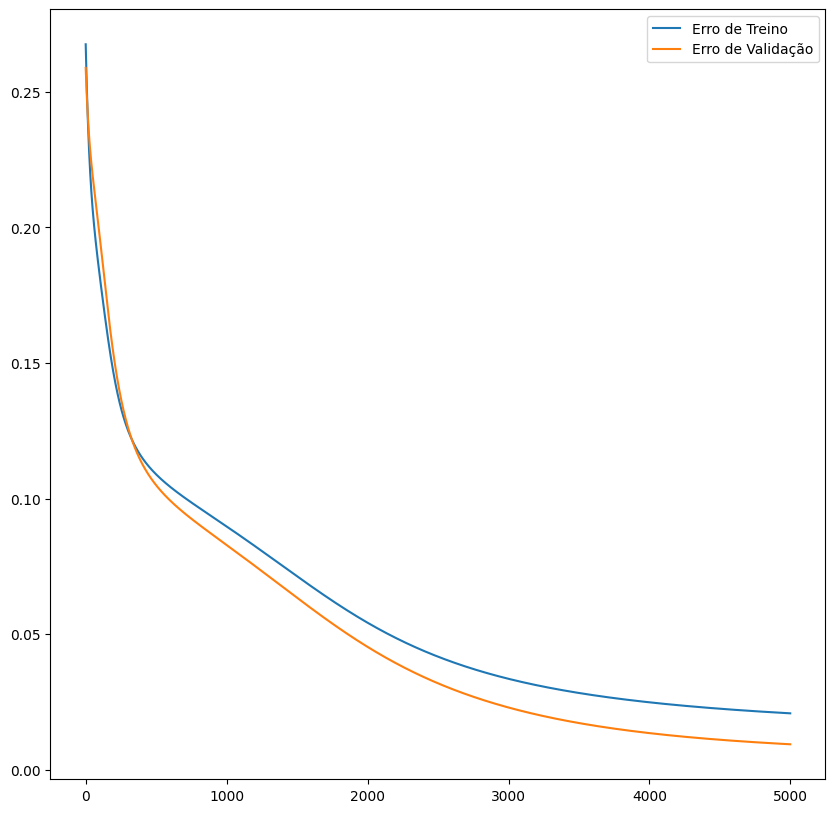

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(x_train)
    predictions_val = model(x_val)
    predictions_test = model(x_test)

error_train = loss_function(predictions_train, y_train)
error_val = loss_function(predictions_val, y_val)
error_test = loss_function(predictions_test, y_test)

print(f"Erro de Treino: {error_train}")
print(f"Erro de Validação: {error_val}")
print(f"Erro de Teste: {error_test}")

Erro de Treino: 0.020790033042430878
Erro de Validação: 0.009378522634506226
Erro de Teste: 0.009378522634506226


### Acurácia da Classificação

In [ ]:
pred_train = torch.argmax(predictions_train, dim=1)
label_train = torch.argmax(y_train, dim=1)
pred_val = torch.argmax(predictions_val, dim=1)
label_val = torch.argmax(y_val, dim=1)
pred_test = torch.argmax(predictions_test, dim=1)
label_test = torch.argmax(y_test, dim=1)

from sklearn.metrics import accuracy_score
acc_train = accuracy_score(label_train, pred_train)
acc_val = accuracy_score(label_val, pred_val)
acc_test = accuracy_score(label_test, pred_test)


print(f"Acurácia de Treino: {acc_train*100:.2f}%")
print(f"Acurácia de Validação: {acc_val*100:.2f}%")
print(f"Acurácia de Teste: {acc_test*100:.2f}%")

Acurácia de Treino: 96.30%
Acurácia de Validação: 100.00%
Acurácia de Teste: 100.00%


## Modelo 2

### Modelo de treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Linear(input_size, output_size)

  def forward(self, x):
    out = self.rede(x)
    return out

### Instanciando o modelo

In [ ]:
input_size = 4
output_size = 3

model2 = MLP(input_size, output_size)

print(model2, end = "\n\n")
summary(model2, (150,4))

MLP(
  (rede): Linear(in_features=4, out_features=3, bias=True)
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 150, 3]              15
Total params: 15
Trainable params: 15
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.2
loss_function2 = nn.MSELoss()
optmizer2 = torch.optim.SGD(model2.parameters(), lr = eta)

### Treinamento da Rede

### Transformação dos Dados em Tensores PyTorch

In [ ]:
x_train2 = torch.FloatTensor(X_train.values)
y_train2 = torch.FloatTensor(Y_train.values)

x_val2 = torch.FloatTensor(X_val.values)
y_val2= torch.FloatTensor(Y_val.values)

x_test2 = torch.FloatTensor(X_val.values)
y_test2 = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device2 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device2} device")

Using cpu device


### Laço de Treino

In [ ]:
def train_network2(model2, optmizer2, loss_function2, x_train2, y_train2, x_val2, y_val2, num_epochs2, train_losses2, val_losses2):
  for epoch in range(num_epochs2):
    optmizer2.zero_grad()

    output_train2 = model2(x_train2)

    loss_train2 = loss_function2(output_train2, y_train2)

    loss_train2.backward()

    optmizer2.step()

    output_val2 = model2(x_val2)
    loss_val2 = loss_function2(output_val2, y_val2)

    train_losses2[epoch] = loss_train2.item()
    val_losses2[epoch] = loss_val2.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs2}, Erro de Treino: {loss_train2.item():.4f}, Erro de Validação: {loss_val2.item():.3f}")

In [ ]:
num_epochs2 = 5000
train_losses2 = np.zeros(num_epochs2)
val_losses2 = np.zeros(num_epochs2)

train_network2(model2, optmizer2, loss_function2, x_train2, y_train2, x_val2, y_val2, num_epochs2, train_losses2, val_losses2)

Epoca: 100 / 5000, Erro de Treino: 0.1160, Erro de Validação: 0.115
Epoca: 200 / 5000, Erro de Treino: 0.1054, Erro de Validação: 0.107
Epoca: 300 / 5000, Erro de Treino: 0.1001, Erro de Validação: 0.103
Epoca: 400 / 5000, Erro de Treino: 0.0968, Erro de Validação: 0.101
Epoca: 500 / 5000, Erro de Treino: 0.0947, Erro de Validação: 0.100
Epoca: 600 / 5000, Erro de Treino: 0.0933, Erro de Validação: 0.099
Epoca: 700 / 5000, Erro de Treino: 0.0924, Erro de Validação: 0.099
Epoca: 800 / 5000, Erro de Treino: 0.0917, Erro de Validação: 0.098
Epoca: 900 / 5000, Erro de Treino: 0.0912, Erro de Validação: 0.098
Epoca: 1000 / 5000, Erro de Treino: 0.0908, Erro de Validação: 0.098
Epoca: 1100 / 5000, Erro de Treino: 0.0906, Erro de Validação: 0.098
Epoca: 1200 / 5000, Erro de Treino: 0.0903, Erro de Validação: 0.098
Epoca: 1300 / 5000, Erro de Treino: 0.0902, Erro de Validação: 0.098
Epoca: 1400 / 5000, Erro de Treino: 0.0900, Erro de Validação: 0.098
Epoca: 1500 / 5000, Erro de Treino: 0.0899,

### Resultados

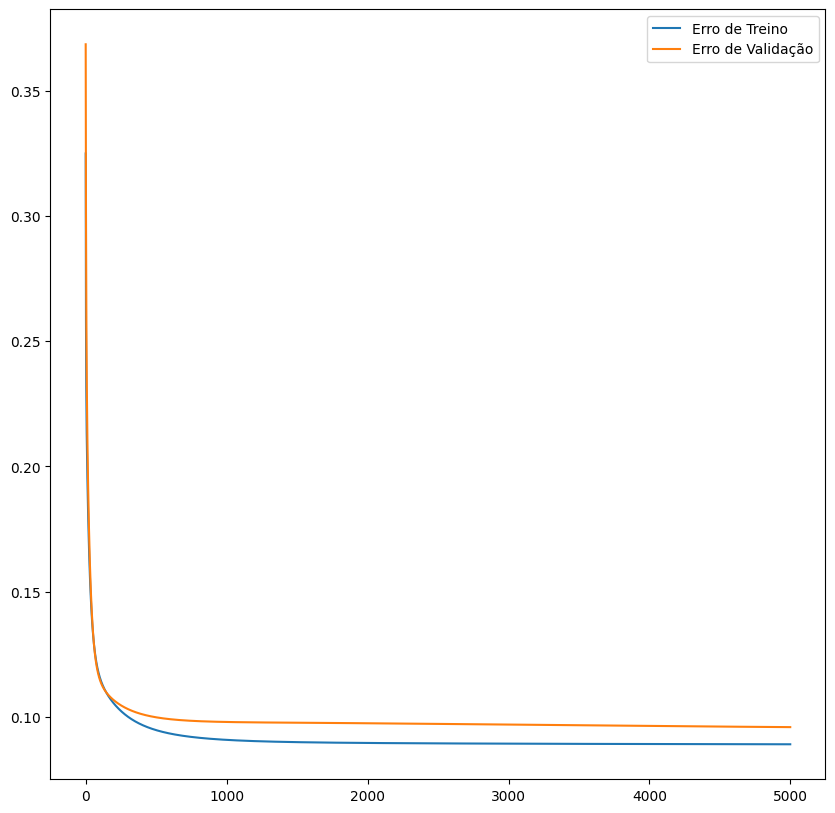

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses2, label='Erro de Treino')
plt.plot(val_losses2, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train2 = []
predictions_val2 = []
predictions_test2 =  []
with torch.no_grad():
    predictions_train2 = model2(x_train2)
    predictions_val2 = model2(x_val2)
    predictions_test2 = model2(x_test2)

error_train2 = loss_function2(predictions_train2, y_train2)
error_val2 = loss_function2(predictions_val2, y_val2)
error_test2 = loss_function2(predictions_test2, y_test2)

print(f"Erro de Treino: {error_train2}")
print(f"Erro de Validação: {error_val2}")
print(f"Erro de Teste: {error_test2}")

Erro de Treino: 0.08907370269298553
Erro de Validação: 0.0959208607673645
Erro de Teste: 0.0959208607673645


### Acurácia da Classificação

In [ ]:
pred_train2 = torch.argmax(predictions_train2, dim=1)
label_train2 = torch.argmax(y_train2, dim=1)
pred_val2 = torch.argmax(predictions_val2, dim=1)
label_val2 = torch.argmax(y_val2, dim=1)
pred_test2 = torch.argmax(predictions_test2, dim=1)
label_test2 = torch.argmax(y_test2, dim=1)

from sklearn.metrics import accuracy_score
acc_train2 = accuracy_score(label_train2, pred_train2)
acc_val2 = accuracy_score(label_val2, pred_val2)
acc_test2 = accuracy_score(label_test2, pred_test2)


print(f"Acurácia de Treino: {acc_train2*100:.2f}%")
print(f"Acurácia de Validação: {acc_val2*100:.2f}%")
print(f"Acurácia de Teste: {acc_test2*100:.2f}%")

Acurácia de Treino: 84.26%
Acurácia de Validação: 77.78%
Acurácia de Teste: 77.78%


## Modelo 3

### Modelo de treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim, 10),
        nn.Tanh(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, output_dim),
        nn.Sigmoid(),
    )

  def forward(self, x):
    out = self.rede(x)
    return out

### Instanciando o modelo

In [ ]:
input_size3 = 4
output_size3 = 3

model3 = MLP(input_size3, output_size3)

print(model3, end = "\n\n")
summary(model3, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=3, bias=True)
    (7): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3              [-1, 150, 10]             110
              ReLU-4              [-1, 150, 10]               0
            Linear-5              [-1, 150, 10]             110
              ReLU-6              [-1, 150, 10]               0
            Linear-7               [-1, 150, 3]              33
           Sigmoid-8               [-1, 150, 3]               0
Total params: 303
Tr

### Otimizador e Função de Custo

In [ ]:
eta3 = 0.2
loss_function3 = nn.MSELoss()
optmizer3 = torch.optim.SGD(model3.parameters(), lr = eta3, momentum = 0.8)

### Treinamento da Rede

### Transformação dos Dados em Tensores PyTorch

In [ ]:
x_train3 = torch.FloatTensor(X_train.values)
y_train3 = torch.FloatTensor(Y_train.values)

x_val3 = torch.FloatTensor(X_val.values)
y_val3= torch.FloatTensor(Y_val.values)

x_test3 = torch.FloatTensor(X_val.values)
y_test3 = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device3 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device3} device")

Using cpu device


### Laço de Treino

In [ ]:
def train_network3(model3, optmizer3, loss_function3, x_train3, y_train3, x_val3, y_val3, num_epochs3, train_losses3, val_losses3):
  for epoch in range(num_epochs3):
    optmizer3.zero_grad()

    output_train3 = model3(x_train3)

    loss_train3 = loss_function3(output_train3, y_train3)

    loss_train3.backward()

    optmizer3.step()

    output_val3 = model3(x_val3)
    loss_val3 = loss_function3(output_val3, y_val3)

    train_losses3[epoch] = loss_train3.item()
    val_losses3[epoch] = loss_val3.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs3}, Erro de Treino: {loss_train3.item():.4f}, Erro de Validação: {loss_val3.item():.3f}")

In [ ]:
num_epochs3 = 5000
train_losses3 = np.zeros(num_epochs3)
val_losses3 = np.zeros(num_epochs3)

train_network3(model3, optmizer3, loss_function3, x_train3, y_train3, x_val3, y_val3, num_epochs3, train_losses3, val_losses3)

Epoca: 100 / 5000, Erro de Treino: 0.1858, Erro de Validação: 0.181
Epoca: 200 / 5000, Erro de Treino: 0.0696, Erro de Validação: 0.056
Epoca: 300 / 5000, Erro de Treino: 0.0185, Erro de Validação: 0.006
Epoca: 400 / 5000, Erro de Treino: 0.0142, Erro de Validação: 0.004
Epoca: 500 / 5000, Erro de Treino: 0.0130, Erro de Validação: 0.003
Epoca: 600 / 5000, Erro de Treino: 0.0124, Erro de Validação: 0.003
Epoca: 700 / 5000, Erro de Treino: 0.0121, Erro de Validação: 0.002
Epoca: 800 / 5000, Erro de Treino: 0.0120, Erro de Validação: 0.001
Epoca: 900 / 5000, Erro de Treino: 0.0119, Erro de Validação: 0.001
Epoca: 1000 / 5000, Erro de Treino: 0.0118, Erro de Validação: 0.001
Epoca: 1100 / 5000, Erro de Treino: 0.0117, Erro de Validação: 0.001
Epoca: 1200 / 5000, Erro de Treino: 0.0117, Erro de Validação: 0.001
Epoca: 1300 / 5000, Erro de Treino: 0.0116, Erro de Validação: 0.000
Epoca: 1400 / 5000, Erro de Treino: 0.0116, Erro de Validação: 0.000
Epoca: 1500 / 5000, Erro de Treino: 0.0116,

### Resultados

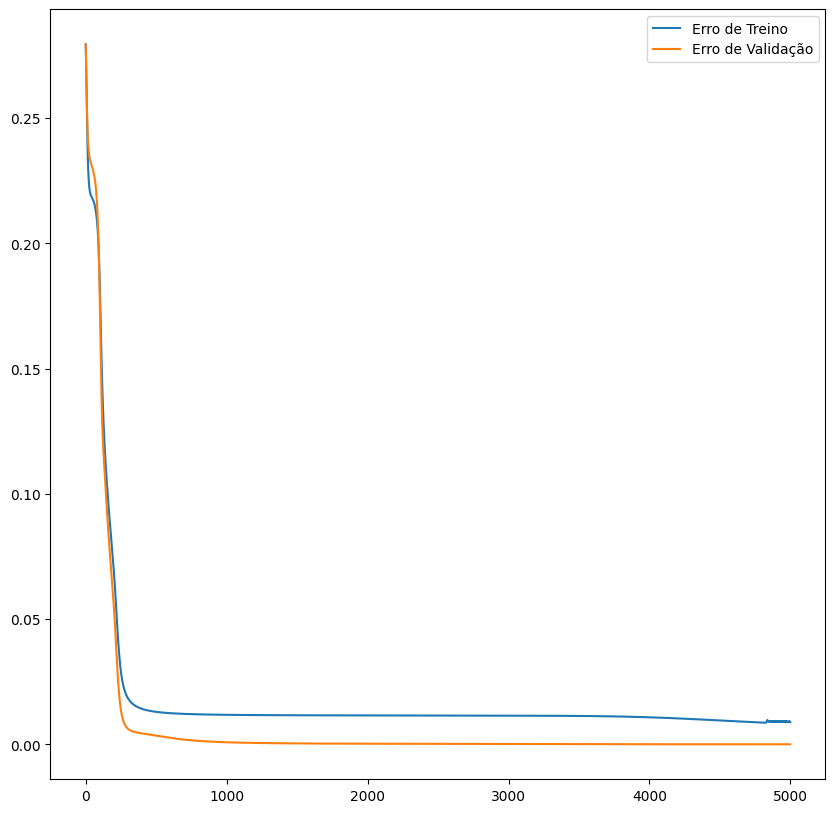

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses3, label='Erro de Treino')
plt.plot(val_losses3, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train3 = []
predictions_val3 = []
predictions_test3 =  []
with torch.no_grad():
    predictions_train3 = model3(x_train3)
    predictions_val3 = model3(x_val3)
    predictions_test3 = model3(x_test3)

error_train3 = loss_function3(predictions_train3, y_train3)
error_val3 = loss_function3(predictions_val3, y_val3)
error_test3 = loss_function3(predictions_test3, y_test3)

print(f"Erro de Treino: {error_train3}")
print(f"Erro de Validação: {error_val3}")
print(f"Erro de Teste: {error_test3}")

Erro de Treino: 0.008907776325941086
Erro de Validação: 1.004872228804743e-05
Erro de Teste: 1.004872228804743e-05


### Acurácia da Classificação

In [ ]:
pred_train3 = torch.argmax(predictions_train3, dim=1)
label_train3 = torch.argmax(y_train3, dim=1)
pred_val3 = torch.argmax(predictions_val3, dim=1)
label_val3 = torch.argmax(y_val3, dim=1)
pred_test3 = torch.argmax(predictions_test3, dim=1)
label_test3 = torch.argmax(y_test3, dim=1)

from sklearn.metrics import accuracy_score
acc_train3 = accuracy_score(label_train3, pred_train3)
acc_val3 = accuracy_score(label_val3, pred_val3)
acc_test3 = accuracy_score(label_test3, pred_test3)

print(f"Acurácia de Treino: {acc_train3*100:.2f}%")
print(f"Acurácia de Validação: {acc_val3*100:.2f}%")
print(f"Acurácia de Teste: {acc_test3*100:.2f}%")

Acurácia de Treino: 99.07%
Acurácia de Validação: 100.00%
Acurácia de Teste: 100.00%


## Modelo 4

### Modelo de treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim, 10),
        nn.Tanh(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, output_dim),
        nn.Sigmoid(),
    )

  def forward(self, x):
    out = self.rede(x)
    return out

### Instanciando o modelo

In [ ]:
input_size4 = 4
output_size4 = 3

model4 = MLP(input_size4, output_size4)

print(model4, end = "\n\n")
summary(model4, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=3, bias=True)
    (9): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3              [-1, 150, 10]             110
              ReLU-4              [-1, 150, 10]               0
            Linear-5              [-1, 150, 10]             110
              ReLU-6              [-1, 150, 10]               0
            Linear-7              [-1, 150, 10]             110
        

### Otimizador e Função de Custo

In [ ]:
eta4 = 0.2
loss_function4 = nn.MSELoss()
optmizer4 = torch.optim.SGD(model4.parameters(), lr = eta4, weight_decay = 0.1)

### Treinamento da Rede

### Transformação dos Dados em Tensores PyTorch

In [ ]:
x_train4 = torch.FloatTensor(X_train.values)
y_train4 = torch.FloatTensor(Y_train.values)

x_val4 = torch.FloatTensor(X_val.values)
y_val4= torch.FloatTensor(Y_val.values)

x_test4 = torch.FloatTensor(X_val.values)
y_test4 = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device4 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device4} device")

Using cpu device


### Laço de Treino

In [ ]:
def train_network4(model4, optmizer4, loss_function4, x_train4, y_train4, x_val4, y_val4, num_epochs4, train_losses4, val_losses4):
  for epoch in range(num_epochs4):
    optmizer4.zero_grad()

    output_train4 = model4(x_train4)

    loss_train4 = loss_function4(output_train4, y_train4)

    loss_train4.backward()

    optmizer4.step()

    output_val4 = model4(x_val4)
    loss_val4 = loss_function4(output_val4, y_val4)

    train_losses4[epoch] = loss_train4.item()
    val_losses4[epoch] = loss_val4.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs4}, Erro de Treino: {loss_train4.item():.3f}, Erro de Validação: {loss_val4.item():.3f}")

In [ ]:
num_epochs4 = 5000
train_losses4 = np.zeros(num_epochs4)
val_losses4 = np.zeros(num_epochs4)

train_network4(model4, optmizer4, loss_function4, x_train4, y_train4, x_val4, y_val4, num_epochs4, train_losses4, val_losses4)

Epoca: 100 / 5000, Erro de Treino: 0.236, Erro de Validação: 0.239
Epoca: 200 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 300 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 400 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 500 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 600 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 700 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 800 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 900 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1000 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1100 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1200 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1300 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1400 / 5000, Erro de Treino: 0.235, Erro de Validação: 0.239
Epoca: 1500 / 5000, Erro de Treino: 0.235, Erro de Valida

### Resultados

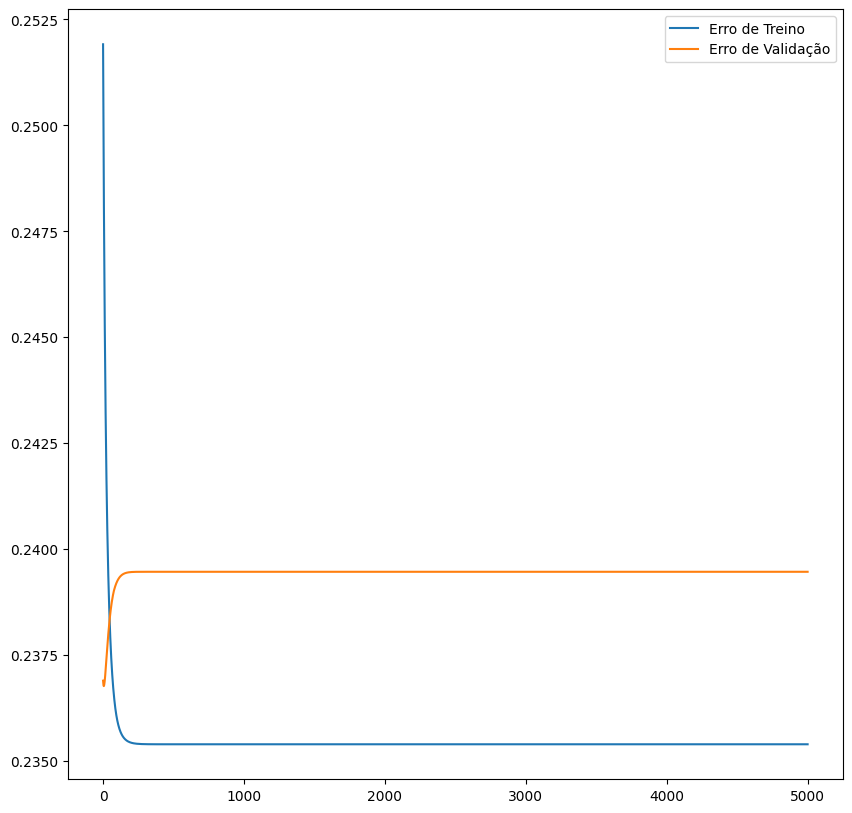

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses4, label='Erro de Treino')
plt.plot(val_losses4, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train4 = []
predictions_val4 = []
predictions_test4 =  []
with torch.no_grad():
    predictions_train4 = model4(x_train4)
    predictions_val4 = model4(x_val4)
    predictions_test4 = model4(x_test4)

error_train4 = loss_function4(predictions_train4, y_train4)
error_val4 = loss_function4(predictions_val4, y_val4)
error_test4 = loss_function4(predictions_test4, y_test4)

print(f"Erro de Treino: {error_train4}")
print(f"Erro de Validação: {error_val4}")
print(f"Erro de Teste: {error_test4}")

Erro de Treino: 0.23539505898952484
Erro de Validação: 0.23946531116962433
Erro de Teste: 0.23946531116962433


### Acurácia da Classificação

In [ ]:
pred_train4 = torch.argmax(predictions_train4, dim=1)
label_train4 = torch.argmax(y_train4, dim=1)
pred_val4 = torch.argmax(predictions_val4, dim=1)
label_val4 = torch.argmax(y_val4, dim=1)
pred_test4 = torch.argmax(predictions_test4, dim=1)
label_test4 = torch.argmax(y_test4, dim=1)

from sklearn.metrics import accuracy_score
acc_train4 = accuracy_score(label_train4, pred_train4)
acc_val4 = accuracy_score(label_val4, pred_val4)
acc_test4 = accuracy_score(label_test4, pred_test4)

print(f"Acurácia de Treino: {acc_train4*100:.2f}%")
print(f"Acurácia de Validação: {acc_val4*100:.2f}%")
print(f"Acurácia de Teste: {acc_test4*100:.2f}%")

Acurácia de Treino: 38.89%
Acurácia de Validação: 14.81%
Acurácia de Teste: 14.81%


## Modelo 5

### Modelo de treino

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MLP, self).__init__()
    self.rede = nn.Sequential(
        nn.Linear(input_dim, 10),
        nn.Tanh(),
        nn.Linear(10, 10),
        nn.ReLU(),
        nn.Linear(10, output_dim),
        nn.Sigmoid(),
    )

  def forward(self, x):
    out = self.rede(x)
    return out

### Instanciando o modelo

In [ ]:
input_size5 = 4
output_size5 = 3

model5 = MLP(input_size5, output_size5)

print(model5, end = "\n\n")
summary(model5, (150,4))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 150, 10]              50
              Tanh-2              [-1, 150, 10]               0
            Linear-3              [-1, 150, 10]             110
              ReLU-4              [-1, 150, 10]               0
            Linear-5               [-1, 150, 3]              33
           Sigmoid-6               [-1, 150, 3]               0
Total params: 193
Trainable params: 193
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated To

### Otimizador e Função de Custo

In [ ]:
eta5 = 0.2
loss_function5 = nn.MSELoss()
optmizer5 = torch.optim.SGD(model5.parameters(), lr = eta5)

### Treinamento da Rede

### Transformação dos Dados em Tensores PyTorch

In [ ]:
x_train5 = torch.FloatTensor(X_train.values)
y_train5 = torch.FloatTensor(Y_train.values)

x_val5 = torch.FloatTensor(X_val.values)
y_val5= torch.FloatTensor(Y_val.values)

x_test5 = torch.FloatTensor(X_val.values)
y_test5 = torch.FloatTensor(Y_val.values)

In [ ]:
# Get cpu, gpu or mps device for training.
device5 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device5} device")

Using cpu device


### Laço de Treino

In [ ]:
def train_network5(model5, optmizer5, loss_function5, x_train5, y_train5, x_val5, y_val5, num_epochs5, train_losses5, val_losses5):
  for epoch in range(num_epochs5):
    optmizer5.zero_grad()

    output_train5 = model5(x_train5)

    loss_train5 = loss_function5(output_train5, y_train5)

    loss_train5.backward()

    optmizer5.step()

    output_val5 = model5(x_val5)
    loss_val5 = loss_function5(output_val5, y_val5)

    train_losses5[epoch] = loss_train5.item()
    val_losses5[epoch] = loss_val5.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs5}, Erro de Treino: {loss_train5.item():.3f}, Erro de Validação: {loss_val5.item():.3f}")

In [ ]:
num_epochs5 = 5000
train_losses5 = np.zeros(num_epochs5)
val_losses5 = np.zeros(num_epochs5)

train_network5(model5, optmizer5, loss_function5, x_train5, y_train5, x_val5, y_val5, num_epochs5, train_losses5, val_losses5)

Epoca: 100 / 5000, Erro de Treino: 0.212, Erro de Validação: 0.227
Epoca: 200 / 5000, Erro de Treino: 0.190, Erro de Validação: 0.203
Epoca: 300 / 5000, Erro de Treino: 0.139, Erro de Validação: 0.141
Epoca: 400 / 5000, Erro de Treino: 0.115, Erro de Validação: 0.111
Epoca: 500 / 5000, Erro de Treino: 0.105, Erro de Validação: 0.099
Epoca: 600 / 5000, Erro de Treino: 0.097, Erro de Validação: 0.090
Epoca: 700 / 5000, Erro de Treino: 0.088, Erro de Validação: 0.081
Epoca: 800 / 5000, Erro de Treino: 0.078, Erro de Validação: 0.071
Epoca: 900 / 5000, Erro de Treino: 0.068, Erro de Validação: 0.060
Epoca: 1000 / 5000, Erro de Treino: 0.056, Erro de Validação: 0.047
Epoca: 1100 / 5000, Erro de Treino: 0.046, Erro de Validação: 0.035
Epoca: 1200 / 5000, Erro de Treino: 0.037, Erro de Validação: 0.026
Epoca: 1300 / 5000, Erro de Treino: 0.031, Erro de Validação: 0.019
Epoca: 1400 / 5000, Erro de Treino: 0.026, Erro de Validação: 0.014
Epoca: 1500 / 5000, Erro de Treino: 0.023, Erro de Valida

### Resultados

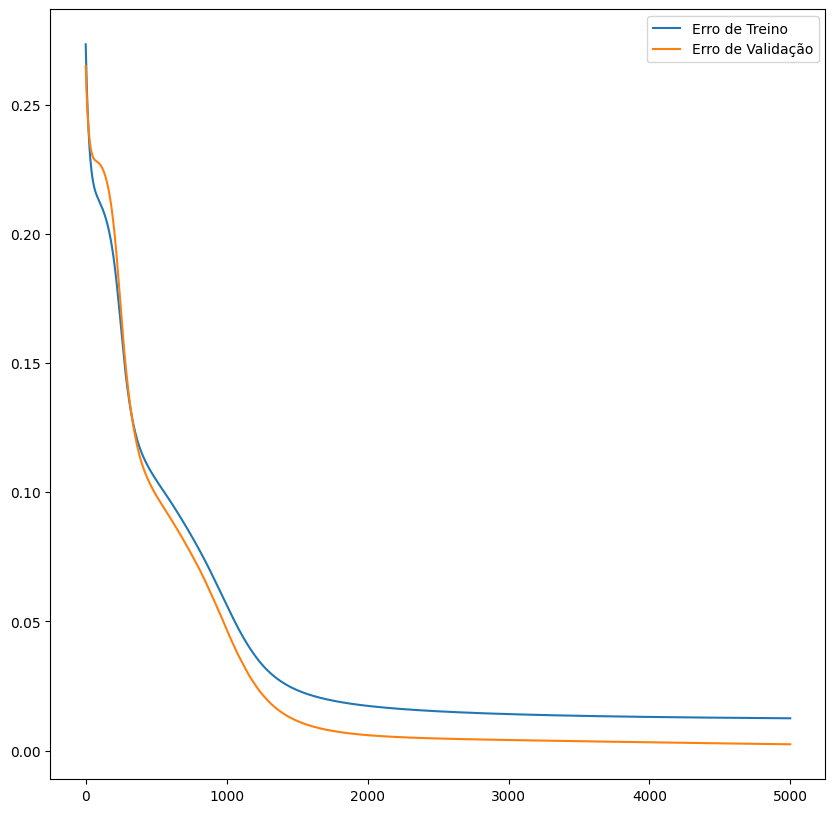

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses5, label='Erro de Treino')
plt.plot(val_losses5, label='Erro de Validação')
plt.legend()
plt.show()

### Erros de Treino / Validação / Teste

In [ ]:
predictions_train5 = []
predictions_val5 = []
predictions_test5 =  []
with torch.no_grad():
    predictions_train5 = model5(x_train5)
    predictions_val5 = model5(x_val5)
    predictions_test5 = model5(x_test5)

error_train5 = loss_function5(predictions_train5, y_train5)
error_val5 = loss_function5(predictions_val5, y_val5)
error_test5 = loss_function5(predictions_test5, y_test5)

print(f"Erro de Treino: {error_train5}")
print(f"Erro de Validação: {error_val5}")
print(f"Erro de Teste: {error_test5}")

Erro de Treino: 0.01247753482311964
Erro de Validação: 0.0024124805349856615
Erro de Teste: 0.0024124805349856615


### Acurácia da Classificação

In [ ]:
pred_train5 = torch.argmax(predictions_train5, dim=1)
label_train5 = torch.argmax(y_train5, dim=1)
pred_val5 = torch.argmax(predictions_val5, dim=1)
label_val5 = torch.argmax(y_val5, dim=1)
pred_test5 = torch.argmax(predictions_test5, dim=1)
label_test5 = torch.argmax(y_test5, dim=1)

from sklearn.metrics import accuracy_score
acc_train5 = accuracy_score(label_train5, pred_train5)
acc_val5 = accuracy_score(label_val5, pred_val5)
acc_test5 = accuracy_score(label_test5, pred_test5)

print(f"Acurácia de Treino: {acc_train5*100:.2f}%")
print(f"Acurácia de Validação: {acc_val5*100:.2f}%")
print(f"Acurácia de Teste: {acc_test5*100:.2f}%")

Acurácia de Treino: 98.15%
Acurácia de Validação: 100.00%
Acurácia de Teste: 100.00%


## Comparação dos Modelos

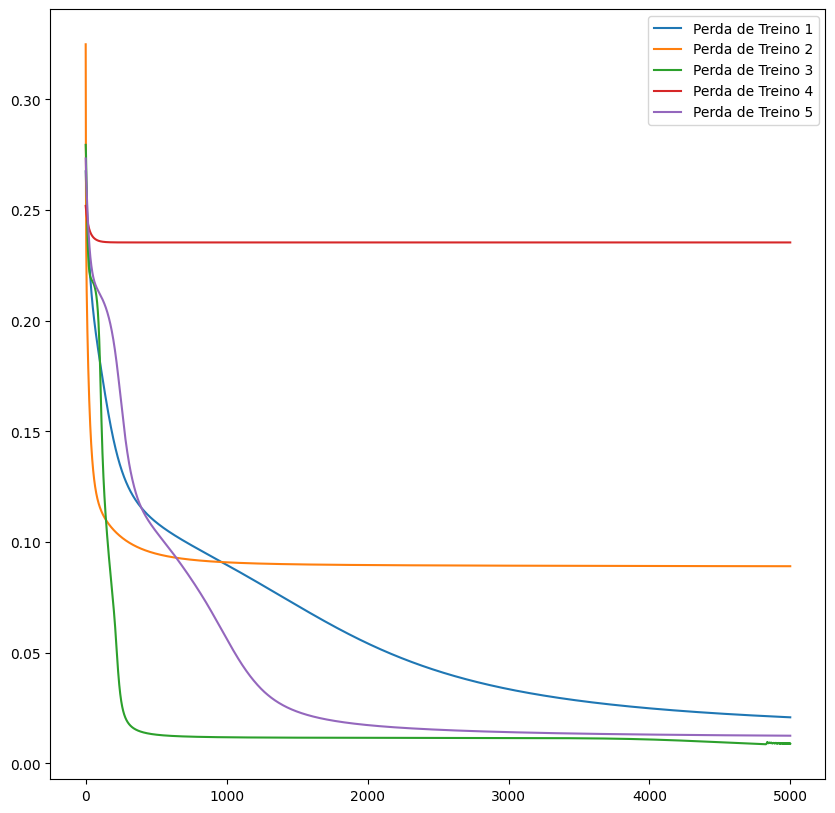

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses, label='Perda de Treino 1')
plt.plot(train_losses2, label='Perda de Treino 2')
plt.plot(train_losses3, label='Perda de Treino 3')
plt.plot(train_losses4, label='Perda de Treino 4')
plt.plot(train_losses5, label='Perda de Treino 5')
plt.legend()
plt.show()

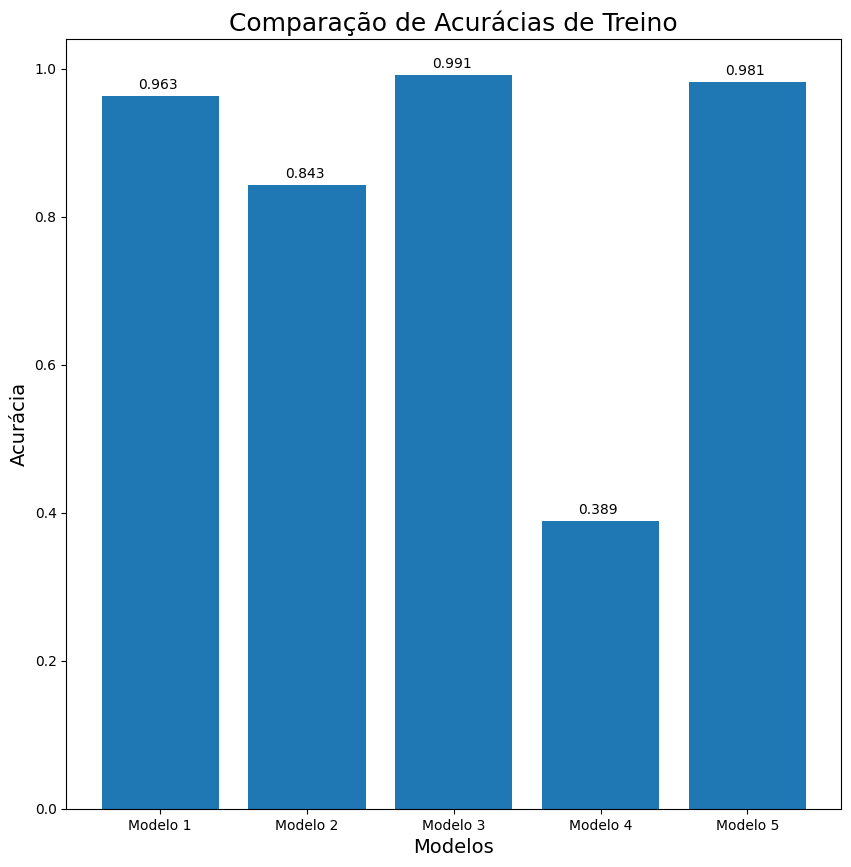

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [acc_train, acc_train2, acc_train3, acc_train4, acc_train5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Acurácias de Treino', fontsize = 18)
ax.set_ylabel('Acurácia', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.15
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

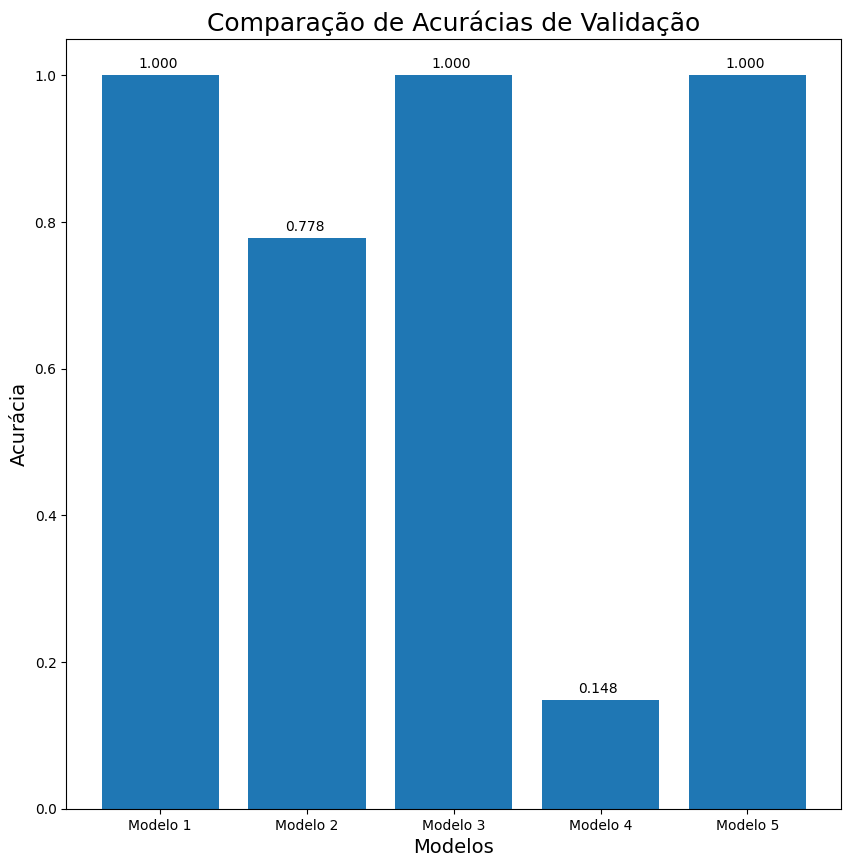

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [acc_val, acc_val2, acc_val3, acc_val4, acc_val5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Acurácias de Validação', fontsize = 18)
ax.set_ylabel('Acurácia', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.10
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

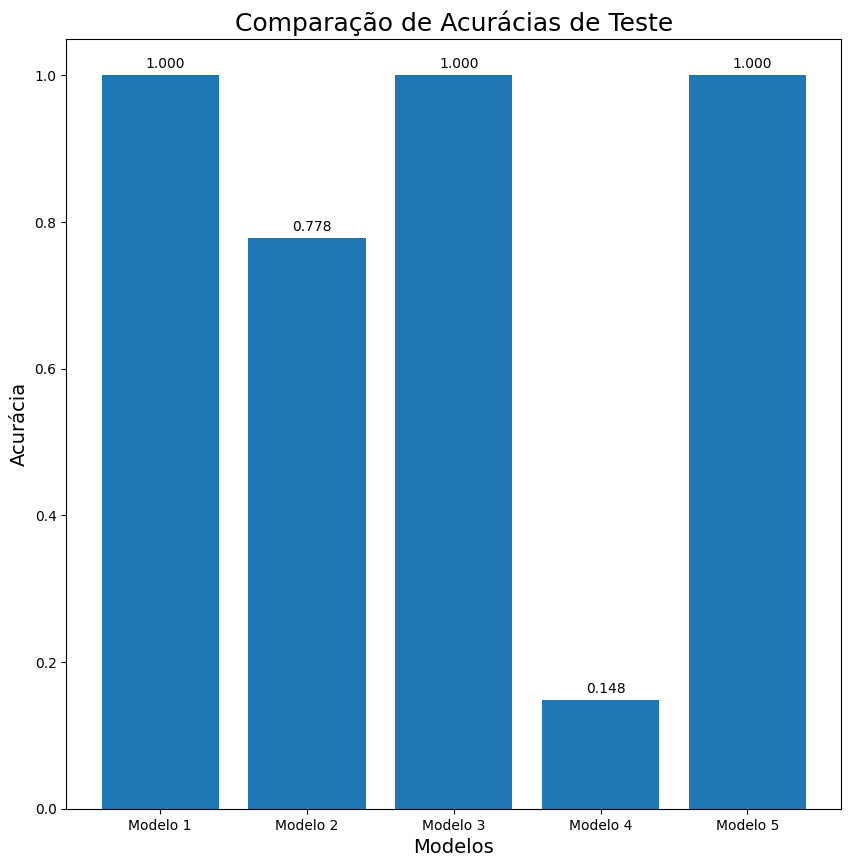

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [acc_test, acc_test2, acc_test3, acc_test4, acc_test5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Acurácias de Teste', fontsize = 18)
ax.set_ylabel('Acurácia', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.1
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

# Regressão

## Pacotes

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary

## Dados

### Geração de Dados

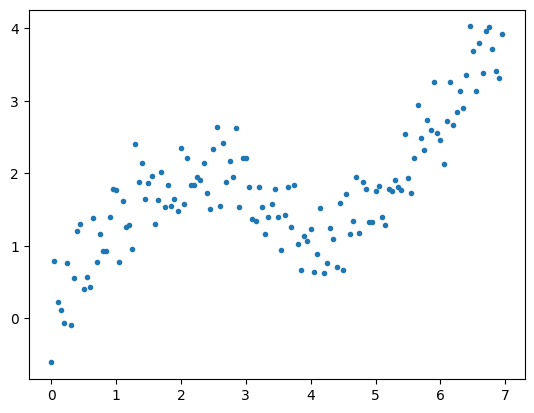

(140,)


In [ ]:
X = np.arange(0,7,0.05)
Y = np.sin(X) + 0.35*np.random.randn(X.shape[0]) + 0.5*X
plt.plot(X,Y, '.')
plt.show()
print(X.shape)

### Separação para Treino / Validação / Teste

(58, 1)
(26, 1)
(56, 1)


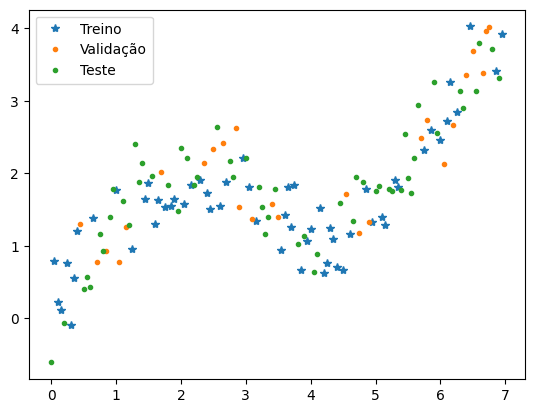

In [ ]:
X = X.reshape((-1, 1))
Y = Y.reshape((-1, 1))

# Separação desenvolvimento (60) e teste (40)
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# Separação treino (70) e validação (30)
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

plt.plot(X_train, Y_train, '*', label='Treino')
plt.plot(X_val, Y_val, '.', label='Validação')
plt.plot(X_test, Y_test, '.', label='Teste')
plt.legend()
plt.show()

## Modelo 1

In [ ]:
class MLPLin(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLPLin,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,output_dim),
        )

    def forward(self,x):
        out =  self.rede(x)
        return out

### Instanciando o Modelo

In [ ]:
input_dim  = 1
output_dim = 1

model = MLPLin(input_dim, output_dim)

print(model, end = "\n\n")
summary(model, (100, 1))

MLPLin(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 100, 1]               2
Total params: 2
Trainable params: 2
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.05
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=eta)

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(Y_train)

x_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(Y_val)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(Y_test)

In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_lossess):
  for epoch in range(num_epochs):
    optimizer.zero_grad()

    output_train = model(x_train)

    loss_train = loss_function(output_train, y_train)

    loss_train.backward()

    optimizer.step()

    output_val = model(x_val)
    loss_val = loss_function(output_val, y_val)

    train_losses[epoch] = loss_train.item()
    val_losses[epoch] = loss_val.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs}, Erro de Treino: {loss_train.item():.4f}, Erro de Validação: {loss_val.item():.3f}")

In [ ]:
num_epochs = 5000
train_losses = np.zeros(num_epochs)
val_losses = np.zeros(num_epochs)

train_network(model, optimizer, loss_function, x_train, y_train, x_val, y_val, num_epochs, train_losses, val_losses)

Epoca: 100 / 5000, Erro de Treino: 0.4144, Erro de Validação: 0.569
Epoca: 200 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 300 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 400 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 500 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 600 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 700 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 800 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 900 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1000 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1100 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1200 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1300 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1400 / 5000, Erro de Treino: 0.4143, Erro de Validação: 0.570
Epoca: 1500 / 5000, Erro de Treino: 0.4143,

### Resultados

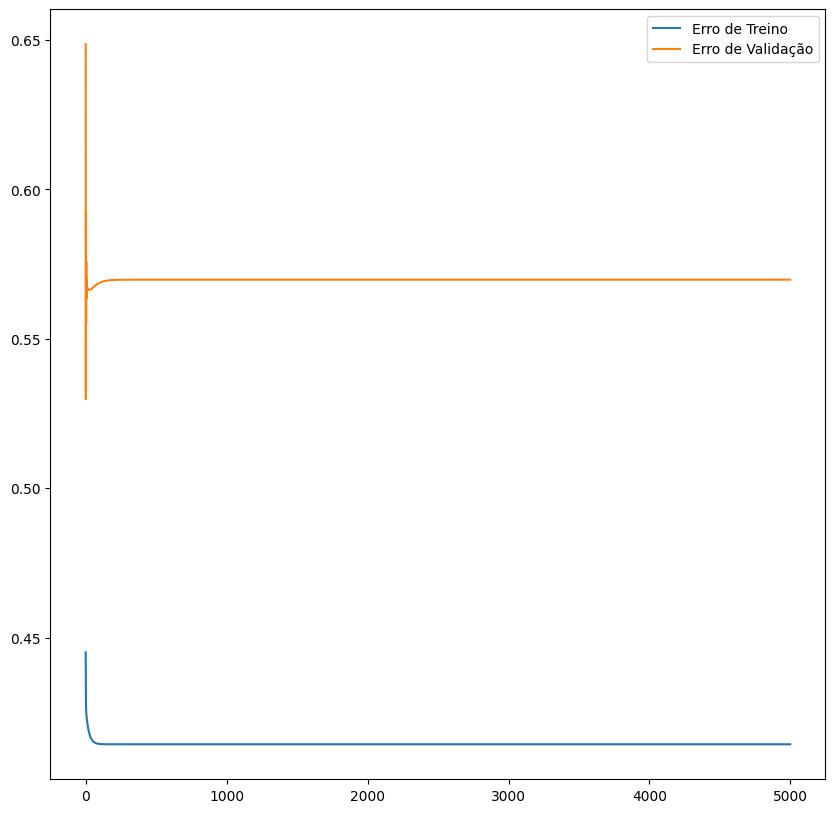

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses, label='Erro de Treino')
plt.plot(val_losses, label='Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train = []
predictions_val = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(x_train)
    predictions_val = model(x_val)
    predictions_test = model(x_test)

erro_train = loss_function(predictions_train,y_train)
erro_val = loss_function(predictions_val,y_val)
erro_test = loss_function(predictions_test,y_test)

print(f"Erro de Treino: {erro_train}")
print(f"Erro de Validação: {erro_val}")
print(f"Erro de Teste: {erro_test}")

Erro de Treino: 0.4142754375934601
Erro de Validação: 0.5697824954986572
Erro de Teste: 0.474687784910202


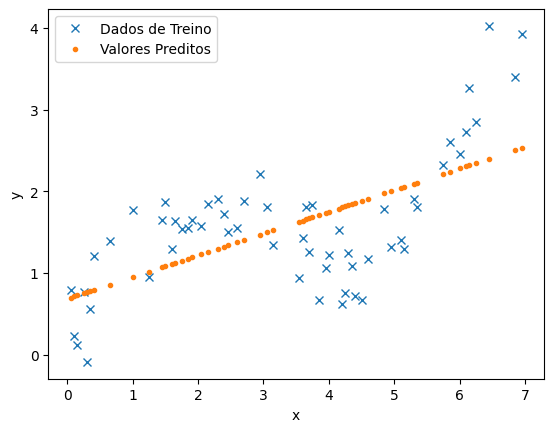

In [ ]:
plt.plot(x_train, y_train, 'x', label = 'Dados de Treino')
plt.plot(x_train, predictions_train, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

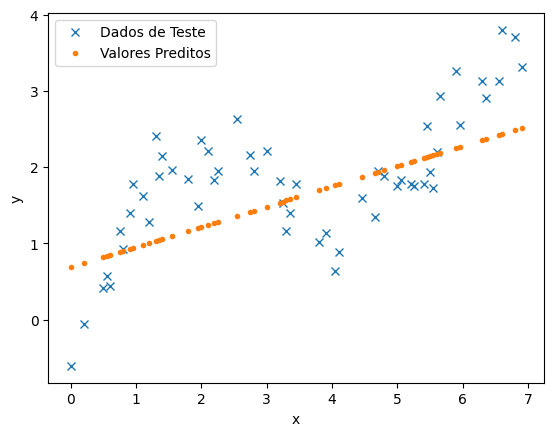

In [ ]:
plt.plot(x_test, y_test, 'x', label = 'Dados de Teste')
plt.plot(x_test, predictions_test, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

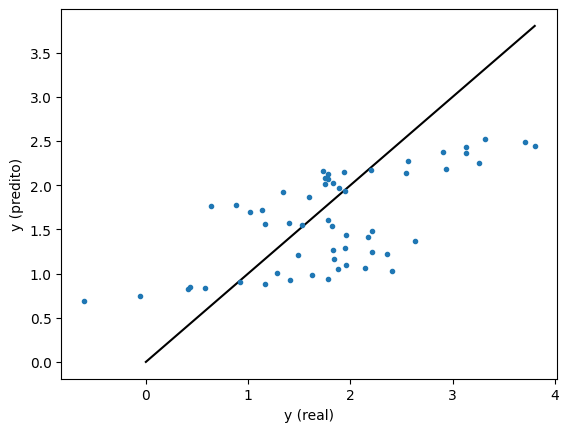

In [ ]:
plt.plot([0,torch.max(y_test)],[0,torch.max(y_test)], 'black')
plt.plot(y_test, predictions_test, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

## Modelo 2

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.ReLU(),
            nn.Linear(512,output_dim),
            nn.ReLU(),
        )

    def forward(self,x):
        out =  self.rede(x)
        return out

### Instanciando o Modelo

In [ ]:
input_dim  = 1
output_dim = 1

model2 = MLP(input_dim, output_dim)

print(model2, end = "\n\n")
summary(model2, (100, 1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): ReLU()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 512]           1,024
              ReLU-2             [-1, 100, 512]               0
            Linear-3               [-1, 100, 1]             513
              ReLU-4               [-1, 100, 1]               0
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 0.01
Estimated Total Size (MB): 0.79
----------------------------------------------------------------


### Otimizador e Função de Custo

In [ ]:
eta = 0.05
loss_function2 = nn.MSELoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr = eta, weight_decay = 0.8)

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train2 = torch.FloatTensor(X_train)
y_train2 = torch.FloatTensor(Y_train)

x_val2 = torch.FloatTensor(X_val)
y_val2 = torch.FloatTensor(Y_val)

x_test2 = torch.FloatTensor(X_test)
y_test2 = torch.FloatTensor(Y_test)

In [ ]:
# Get cpu, gpu or mps device for training.
device2 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device2} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network2(model2, optimizer2, loss_function2, x_train2, y_train2, x_val2, y_val2, num_epochs2, train_losses2, val_losses2):
  for epoch in range(num_epochs2):
    optimizer2.zero_grad()

    output_train2 = model2(x_train2)

    loss_train2 = loss_function2(output_train2, y_train2)

    loss_train2.backward()

    optimizer2.step()

    output_val2 = model2(x_val2)
    loss_val2 = loss_function2(output_val2, y_val2)

    train_losses2[epoch] = loss_train2.item()
    val_losses2[epoch] = loss_val2.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs2}, Erro de Treino: {loss_train2.item():.3f}, Erro de Validação: {loss_val2.item():.3f}")

In [ ]:
num_epochs = 5000
train_losses2 = np.zeros(num_epochs)
val_losses2 = np.zeros(num_epochs)

train_network2(model2, optimizer2, loss_function2, x_train2, y_train2, x_val2, y_val2, num_epochs, train_losses2, val_losses2)

Epoca: 100 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 200 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 300 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 400 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 500 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 600 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 700 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 800 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 900 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1000 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1100 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1200 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1300 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1400 / 5000, Erro de Treino: 3.161, Erro de Validação: 5.392
Epoca: 1500 / 5000, Erro de Treino: 3.161, Erro de Valida

### Resultados

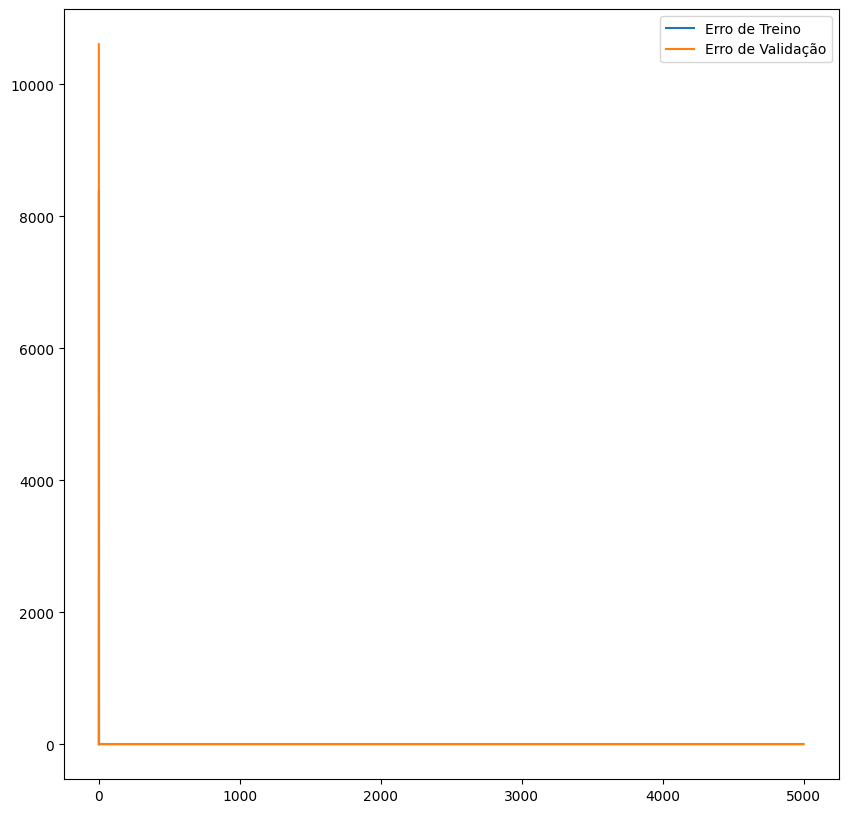

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses2, label = 'Erro de Treino')
plt.plot(val_losses2, label = 'Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train2 = []
predictions_val2 = []
predictions_test2 =  []
with torch.no_grad():
    predictions_train2 = model2(x_train2)
    predictions_val2 = model2(x_val2)
    predictions_test2 = model2(x_test2)

erro_train2 = loss_function2(predictions_train2, y_train2)
erro_val2 = loss_function2(predictions_val2, y_val2)
erro_test2 = loss_function2(predictions_test2, y_test2)

print(f"Erro de Treino: {erro_train2}")
print(f"Erro de Validação: {erro_val2}")
print(f"Erro de Teste: {erro_test2}")

Erro de Treino: 3.1614930629730225
Erro de Validação: 5.3924641609191895
Erro de Teste: 4.076087474822998


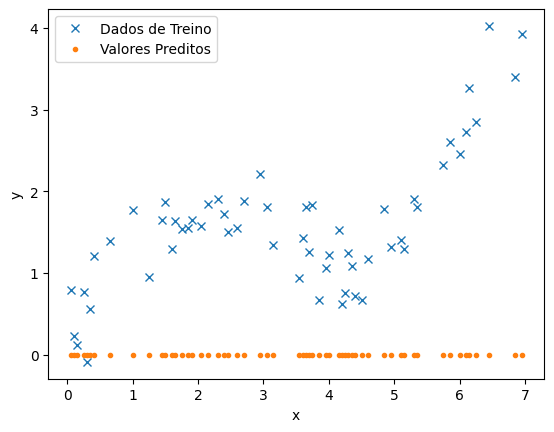

In [ ]:
plt.plot(x_train2, y_train2, 'x', label = 'Dados de Treino')
plt.plot(x_train2, predictions_train2, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

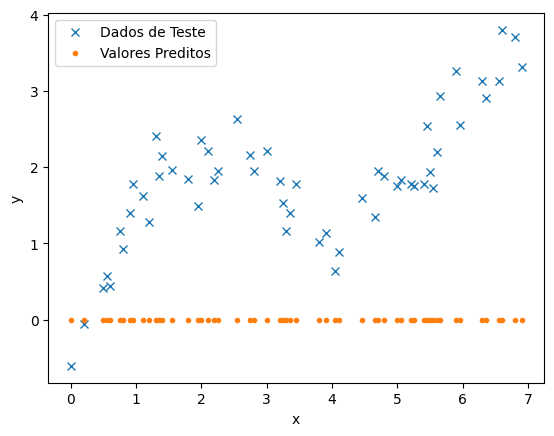

In [ ]:
plt.plot(x_test2, y_test2, 'x', label = 'Dados de Teste')
plt.plot(x_test2, predictions_test2, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

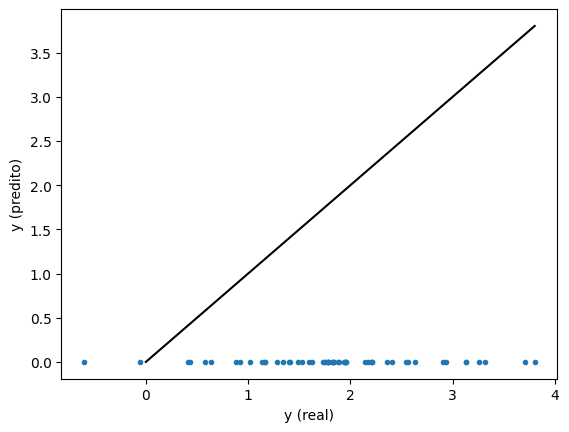

In [ ]:
plt.plot([0,torch.max(y_test2)], [0,torch.max(y_test2)], 'black')
plt.plot(y_test2, predictions_test2, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

## Modelo 3


In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid(),
        )

    def forward(self,x):
        out =  self.rede(x)
        return out

### Instanciando o Modelo

In [ ]:
input_dim  = 1
output_dim = 1

model3 = MLP(input_dim, output_dim)

print(model3, end = "\n\n")
summary(model3, (100, 1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 512]           1,024
              ReLU-2             [-1, 100, 512]               0
            Linear-3             [-1, 100, 256]         131,328
              ReLU-4             [-1, 100, 256]               0
            Linear-5               [-1, 100, 1]             257
           Sigmoid-6               [-1, 100, 1]               0
Total params: 132,609
Trainable params: 132,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.17
Params size (MB): 0.51


### Otimizador e Função de Custo

In [ ]:
eta = 0.2
loss_function3 = nn.MSELoss()
optimizer3 = torch.optim.SGD(model3.parameters(), lr = eta)

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train3 = torch.FloatTensor(X_train)
y_train3 = torch.FloatTensor(Y_train)

x_val3 = torch.FloatTensor(X_val)
y_val3 = torch.FloatTensor(Y_val)

x_test3 = torch.FloatTensor(X_test)
y_test3 = torch.FloatTensor(Y_test)

In [ ]:
# Get cpu, gpu or mps device for training.
device3 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device3} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network3(model3, optimizer3, loss_function3, x_train3, y_train3, x_val3, y_val3, num_epochs3, train_losses3, val_losses3):
  for epoch in range(num_epochs3):
    optimizer3.zero_grad()

    output_train3 = model3(x_train3)

    loss_train3 = loss_function3(output_train3, y_train3)

    loss_train3.backward()

    optimizer3.step()

    output_val3 = model3(x_val3)
    loss_val3 = loss_function3(output_val3, y_val3)

    train_losses3[epoch] = loss_train3.item()
    val_losses3[epoch] = loss_val3.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs3}, Erro de Treino: {loss_train3.item():.3f}, Erro de Validação: {loss_val3.item():.3f}")

In [ ]:
num_epochs = 5000
train_losses3 = np.zeros(num_epochs)
val_losses3 = np.zeros(num_epochs)

train_network3(model3, optimizer3, loss_function3, x_train3, y_train3, x_val3, y_val3, num_epochs, train_losses3, val_losses3)

Epoca: 100 / 5000, Erro de Treino: 1.011, Erro de Validação: 2.156
Epoca: 200 / 5000, Erro de Treino: 1.008, Erro de Validação: 2.156
Epoca: 300 / 5000, Erro de Treino: 0.981, Erro de Validação: 2.162
Epoca: 400 / 5000, Erro de Treino: 0.980, Erro de Validação: 2.162
Epoca: 500 / 5000, Erro de Treino: 0.979, Erro de Validação: 2.161
Epoca: 600 / 5000, Erro de Treino: 0.979, Erro de Validação: 2.161
Epoca: 700 / 5000, Erro de Treino: 0.979, Erro de Validação: 2.161
Epoca: 800 / 5000, Erro de Treino: 0.978, Erro de Validação: 2.160
Epoca: 900 / 5000, Erro de Treino: 0.978, Erro de Validação: 2.160
Epoca: 1000 / 5000, Erro de Treino: 0.977, Erro de Validação: 2.160
Epoca: 1100 / 5000, Erro de Treino: 0.977, Erro de Validação: 2.160
Epoca: 1200 / 5000, Erro de Treino: 0.977, Erro de Validação: 2.159
Epoca: 1300 / 5000, Erro de Treino: 0.977, Erro de Validação: 2.159
Epoca: 1400 / 5000, Erro de Treino: 0.976, Erro de Validação: 2.159
Epoca: 1500 / 5000, Erro de Treino: 0.976, Erro de Valida

### Resultados

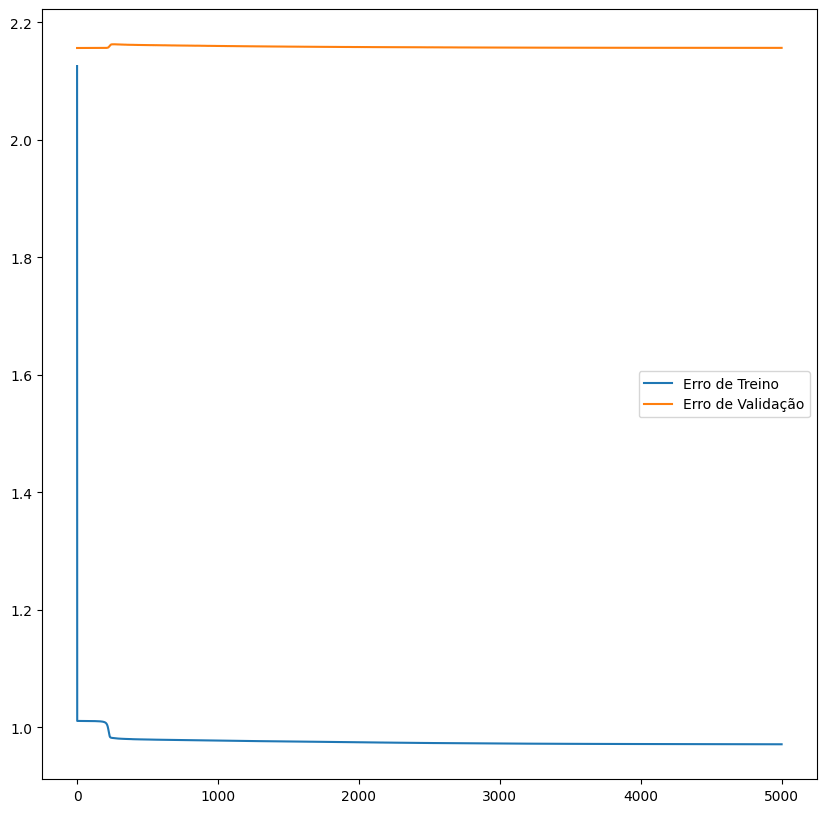

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses3, label = 'Erro de Treino')
plt.plot(val_losses3, label = 'Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train3 = []
predictions_val3 = []
predictions_test3 =  []
with torch.no_grad():
    predictions_train3 = model3(x_train3)
    predictions_val3 = model3(x_val3)
    predictions_test3 = model3(x_test3)

erro_train3 = loss_function3(predictions_train3, y_train3)
erro_val3 = loss_function3(predictions_val3, y_val3)
erro_test3 = loss_function3(predictions_test3, y_test3)

print(f"Erro de Treino: {erro_train3}")
print(f"Erro de Validação: {erro_val3}")
print(f"Erro de Teste: {erro_test3}")

Erro de Treino: 0.9712851047515869
Erro de Validação: 2.156531810760498
Erro de Teste: 1.3956658840179443


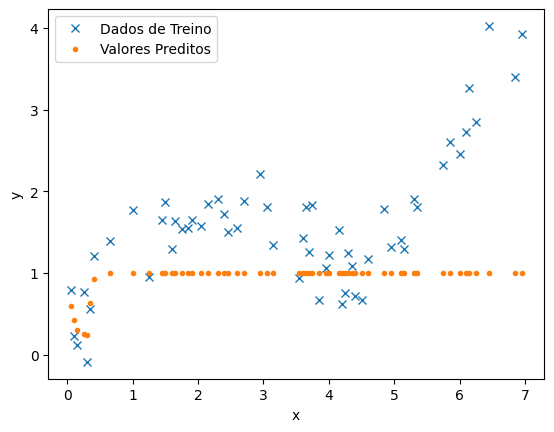

In [ ]:
plt.plot(x_train3, y_train3, 'x', label = 'Dados de Treino')
plt.plot(x_train3, predictions_train3, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

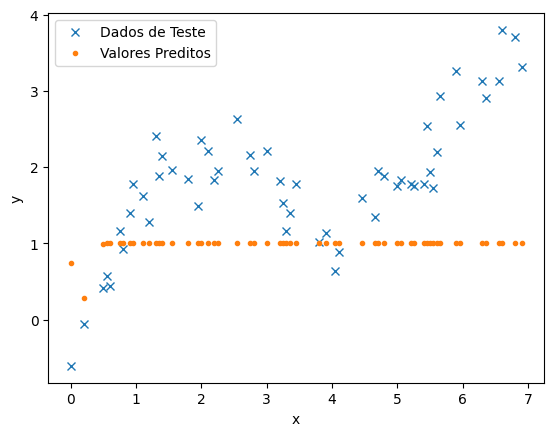

In [ ]:
plt.plot(x_test3, y_test3, 'x', label = 'Dados de Teste')
plt.plot(x_test3, predictions_test3, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

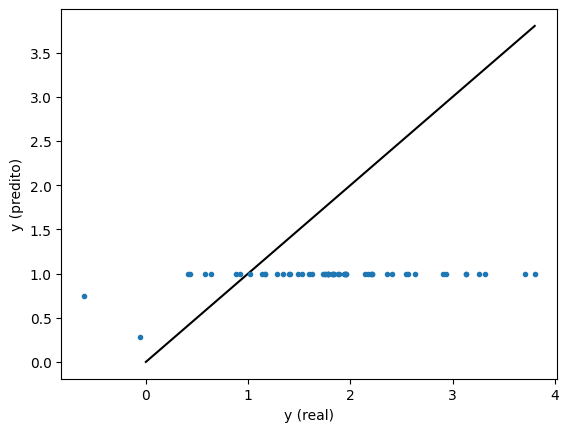

In [ ]:
plt.plot([0,torch.max(y_test3)], [0,torch.max(y_test3)], 'black')
plt.plot(y_test3, predictions_test3, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

## Modelo 4

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,output_dim),
        )

    def forward(self,x):
        out =  self.rede(x)
        return out

### Instanciando o Modelo

In [ ]:
input_dim  = 1
output_dim = 1

model4 = MLP(input_dim, output_dim)

print(model4, end = "\n\n")
summary(model4, (100, 1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 512]           1,024
              ReLU-2             [-1, 100, 512]               0
            Linear-3             [-1, 100, 256]         131,328
              ReLU-4             [-1, 100, 256]               0
            Linear-5             [-1, 100, 128]          32,896
              ReLU-6             [-1, 100, 128]               0
            Linear-7              [-1, 100, 64]           8,256
              ReLU-8 

### Otimizador e Função de Custo

In [ ]:
eta = 0.05
loss_function4 = nn.MSELoss()
optimizer4 = torch.optim.SGD(model4.parameters(), lr = eta)

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train4 = torch.FloatTensor(X_train)
y_train4 = torch.FloatTensor(Y_train)

x_val4 = torch.FloatTensor(X_val)
y_val4 = torch.FloatTensor(Y_val)

x_test4 = torch.FloatTensor(X_test)
y_test4 = torch.FloatTensor(Y_test)

In [ ]:
# Get cpu, gpu or mps device for training.
device4 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device4} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network4(model4, optimizer4, loss_function4, x_train4, y_train4, x_val4, y_val4, num_epochs4, train_losses4, val_losses4):
  for epoch in range(num_epochs4):
    optimizer4.zero_grad()

    output_train4 = model4(x_train4)

    loss_train4 = loss_function4(output_train4, y_train4)

    loss_train4.backward()

    optimizer4.step()

    output_val4 = model4(x_val4)
    loss_val4 = loss_function4(output_val4, y_val4)

    train_losses4[epoch] = loss_train4.item()
    val_losses4[epoch] = loss_val4.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs4}, Erro de Treino: {loss_train4.item():.3f}, Erro de Validação: {loss_val4.item():.3f}")

In [ ]:
num_epochs = 5000
train_losses4 = np.zeros(num_epochs)
val_losses4 = np.zeros(num_epochs)

train_network4(model4, optimizer4, loss_function4, x_train4, y_train4, x_val4, y_val4, num_epochs, train_losses4, val_losses4)

Epoca: 100 / 5000, Erro de Treino: 0.446, Erro de Validação: 0.934
Epoca: 200 / 5000, Erro de Treino: 0.420, Erro de Validação: 0.828
Epoca: 300 / 5000, Erro de Treino: 0.405, Erro de Validação: 0.862
Epoca: 400 / 5000, Erro de Treino: 0.388, Erro de Validação: 0.980
Epoca: 500 / 5000, Erro de Treino: 0.361, Erro de Validação: 1.047
Epoca: 600 / 5000, Erro de Treino: 0.310, Erro de Validação: 0.867
Epoca: 700 / 5000, Erro de Treino: 0.284, Erro de Validação: 0.931
Epoca: 800 / 5000, Erro de Treino: 0.257, Erro de Validação: 0.852
Epoca: 900 / 5000, Erro de Treino: 0.225, Erro de Validação: 0.776
Epoca: 1000 / 5000, Erro de Treino: 0.199, Erro de Validação: 0.694
Epoca: 1100 / 5000, Erro de Treino: 0.192, Erro de Validação: 0.670
Epoca: 1200 / 5000, Erro de Treino: 0.180, Erro de Validação: 0.614
Epoca: 1300 / 5000, Erro de Treino: 0.150, Erro de Validação: 0.472
Epoca: 1400 / 5000, Erro de Treino: 0.154, Erro de Validação: 0.504
Epoca: 1500 / 5000, Erro de Treino: 0.140, Erro de Valida

### Resultados

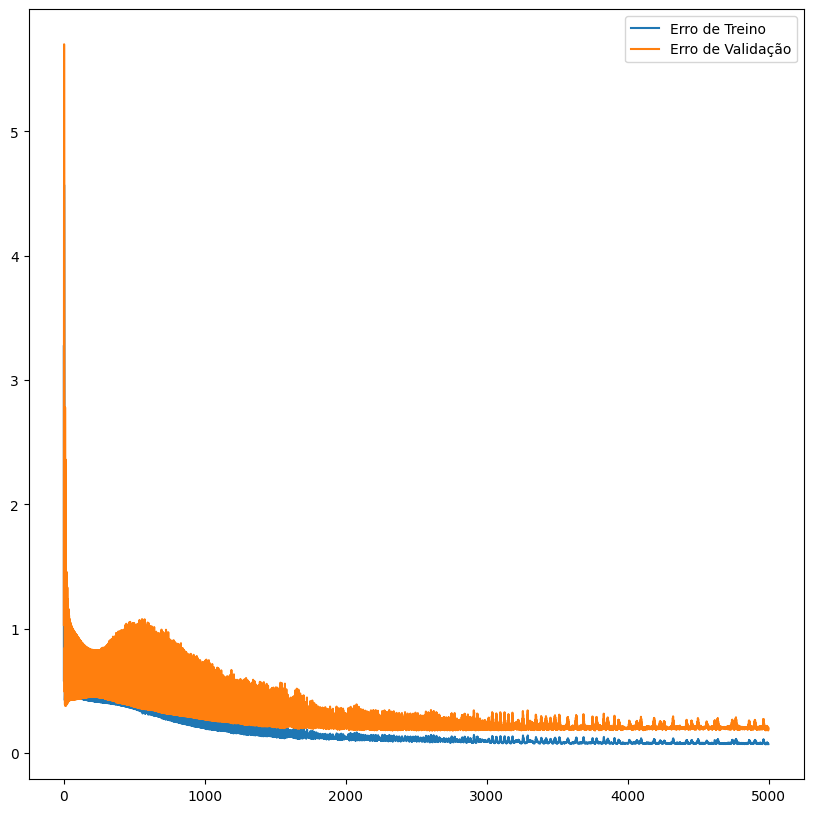

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses4, label = 'Erro de Treino')
plt.plot(val_losses4, label = 'Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train4 = []
predictions_val4 = []
predictions_test4 =  []
with torch.no_grad():
    predictions_train4 = model4(x_train4)
    predictions_val4 = model4(x_val4)
    predictions_test4 = model4(x_test4)

erro_train4 = loss_function4(predictions_train4, y_train4)
erro_val4 = loss_function4(predictions_val4, y_val4)
erro_test4 = loss_function4(predictions_test4, y_test4)

print(f"Erro de Treino: {erro_train4}")
print(f"Erro de Validação: {erro_val4}")
print(f"Erro de Teste: {erro_test4}")

Erro de Treino: 0.07216238230466843
Erro de Validação: 0.20095857977867126
Erro de Teste: 0.2209928333759308


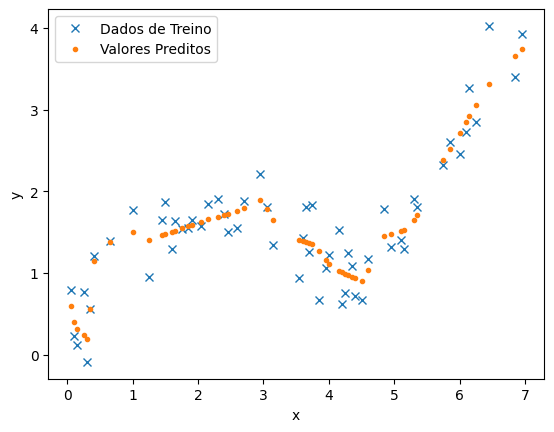

In [ ]:
plt.plot(x_train4, y_train4, 'x', label = 'Dados de Treino')
plt.plot(x_train4, predictions_train4, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

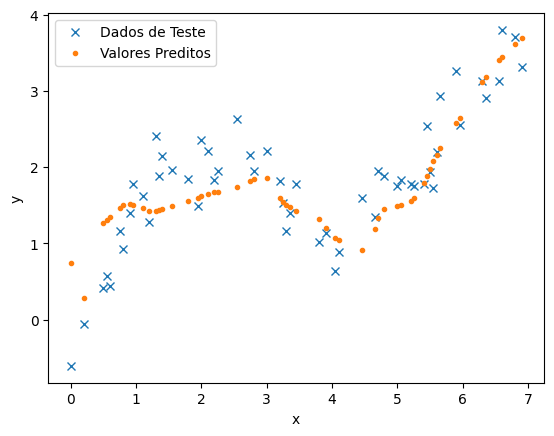

In [ ]:
plt.plot(x_test4, y_test4, 'x', label = 'Dados de Teste')
plt.plot(x_test4, predictions_test4, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

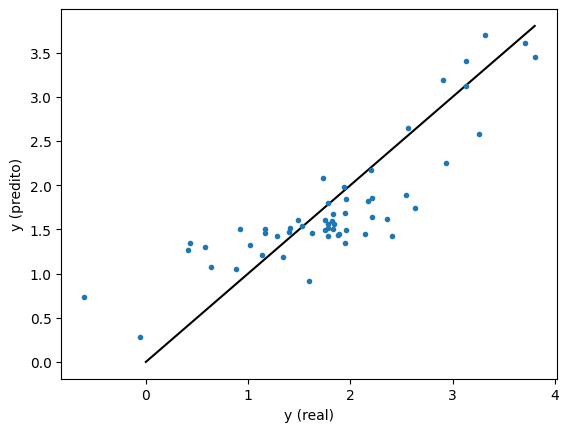

In [ ]:
plt.plot([0,torch.max(y_test4)], [0,torch.max(y_test4)], 'black')
plt.plot(y_test4, predictions_test4, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

## Modelo 5

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(MLP,self).__init__()
        self.rede = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, output_dim)
        )

    def forward(self,x):
        out =  self.rede(x)
        return out

### Instanciando o Modelo

In [ ]:
input_dim  = 1
output_dim = 1

model5 = MLP(input_dim, output_dim)

print(model5, end = "\n\n")
summary(model5, (100, 1))

MLP(
  (rede): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=16, bias=True)
    (11): ReLU()
    (12): Linear(in_features=16, out_features=8, bias=True)
    (13): ReLU()
    (14): Linear(in_features=8, out_features=1, bias=True)
  )
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 512]           1,024
              ReLU-2             [-1, 100, 512]               0
            Linear-3             [-1, 100, 256]         131,328
              ReLU-4             [-1, 100, 256

### Otimizador e Função de Custo

In [ ]:
eta = 0.05
loss_function5 = nn.MSELoss()
optimizer5 = torch.optim.SGD(model5.parameters(), lr = eta, momentum = 0.3, weight_decay = 0.01)

### Transformação dos Dados em Tensores Pytorch

In [ ]:
x_train5 = torch.FloatTensor(X_train)
y_train5 = torch.FloatTensor(Y_train)

x_val5 = torch.FloatTensor(X_val)
y_val5 = torch.FloatTensor(Y_val)

x_test5 = torch.FloatTensor(X_test)
y_test5 = torch.FloatTensor(Y_test)

In [ ]:
# Get cpu, gpu or mps device for training.
device5 = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device5} device")

Using cpu device


### Laço de Treinamento

In [ ]:
def train_network5(model5, optimizer5, loss_function5, x_train5, y_train5, x_val5, y_val5, num_epochs5, train_losses5, val_losses5):
  for epoch in range(num_epochs5):
    optimizer5.zero_grad()

    output_train5 = model5(x_train5)

    loss_train5 = loss_function5(output_train5, y_train5)

    loss_train5.backward()

    optimizer5.step()

    output_val5 = model5(x_val5)
    loss_val5 = loss_function5(output_val5, y_val5)

    train_losses5[epoch] = loss_train5.item()
    val_losses5[epoch] = loss_val5.item()

    if (epoch + 1) % 100 == 0:
      print(f"Epoca: {epoch + 1} / {num_epochs5}, Erro de Treino: {loss_train5.item():.3f}, Erro de Validação: {loss_val5.item():.3f}")

In [ ]:
num_epochs = 5000
train_losses5 = np.zeros(num_epochs)
val_losses5 = np.zeros(num_epochs)

train_network5(model5, optimizer5, loss_function5, x_train5, y_train5, x_val5, y_val5, num_epochs, train_losses5, val_losses5)

Epoca: 100 / 5000, Erro de Treino: 0.427, Erro de Validação: 0.591
Epoca: 200 / 5000, Erro de Treino: 0.408, Erro de Validação: 0.562
Epoca: 300 / 5000, Erro de Treino: 0.420, Erro de Validação: 0.442
Epoca: 400 / 5000, Erro de Treino: 0.453, Erro de Validação: 0.377
Epoca: 500 / 5000, Erro de Treino: 0.423, Erro de Validação: 0.330
Epoca: 600 / 5000, Erro de Treino: 0.401, Erro de Validação: 0.304
Epoca: 700 / 5000, Erro de Treino: 0.382, Erro de Validação: 0.271
Epoca: 800 / 5000, Erro de Treino: 0.384, Erro de Validação: 0.245
Epoca: 900 / 5000, Erro de Treino: 0.298, Erro de Validação: 0.225
Epoca: 1000 / 5000, Erro de Treino: 0.217, Erro de Validação: 0.202
Epoca: 1100 / 5000, Erro de Treino: 0.243, Erro de Validação: 0.211
Epoca: 1200 / 5000, Erro de Treino: 0.226, Erro de Validação: 0.206
Epoca: 1300 / 5000, Erro de Treino: 0.192, Erro de Validação: 0.193
Epoca: 1400 / 5000, Erro de Treino: 0.208, Erro de Validação: 0.200
Epoca: 1500 / 5000, Erro de Treino: 0.179, Erro de Valida

### Resultados

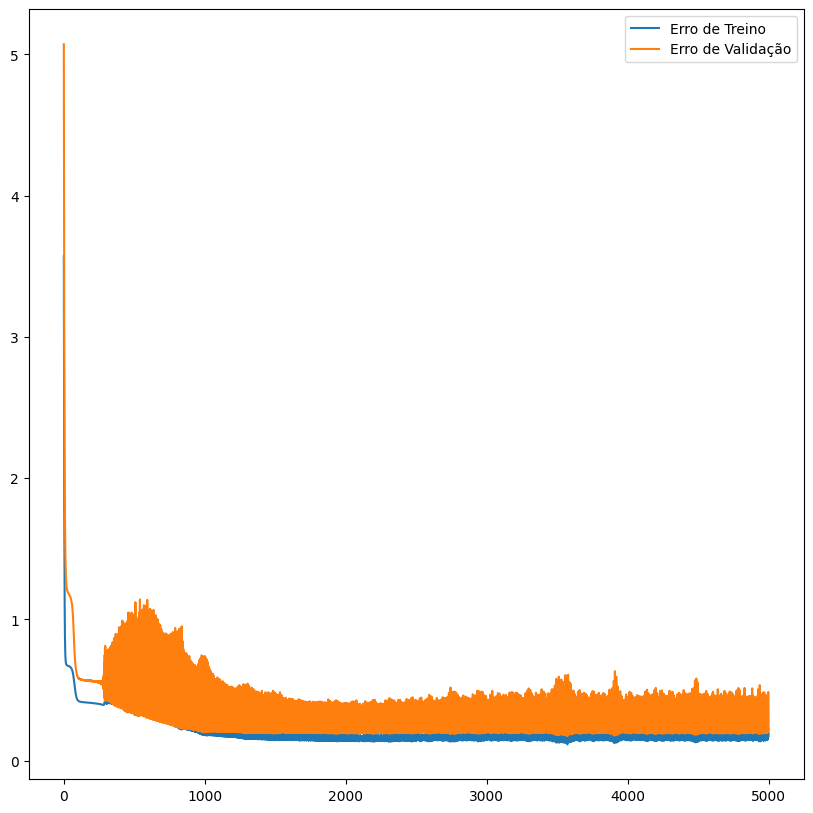

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(train_losses5, label = 'Erro de Treino')
plt.plot(val_losses5, label = 'Erro de Validação')
plt.legend()
plt.show()

In [ ]:
predictions_train5 = []
predictions_val5 = []
predictions_test5 =  []
with torch.no_grad():
    predictions_train5 = model5(x_train5)
    predictions_val5 = model5(x_val5)
    predictions_test5 = model5(x_test5)

erro_train5 = loss_function5(predictions_train5, y_train5)
erro_val5 = loss_function5(predictions_val5, y_val5)
erro_test5 = loss_function5(predictions_test5, y_test5)

print(f"Erro de Treino: {erro_train5}")
print(f"Erro de Validação: {erro_val5}")
print(f"Erro de Teste: {erro_test5}")

Erro de Treino: 0.16863667964935303
Erro de Validação: 0.21736527979373932
Erro de Teste: 0.20417913794517517


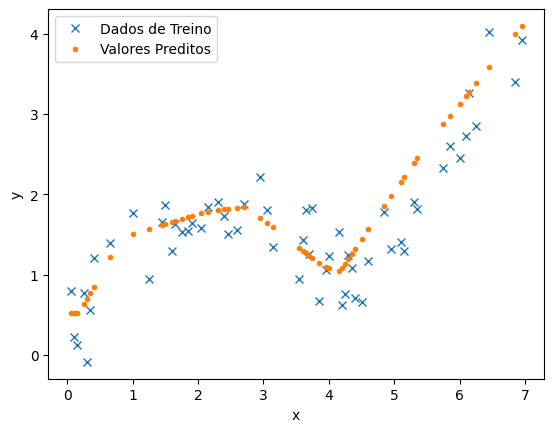

In [ ]:
plt.plot(x_train5, y_train5, 'x', label = 'Dados de Treino')
plt.plot(x_train5, predictions_train5, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

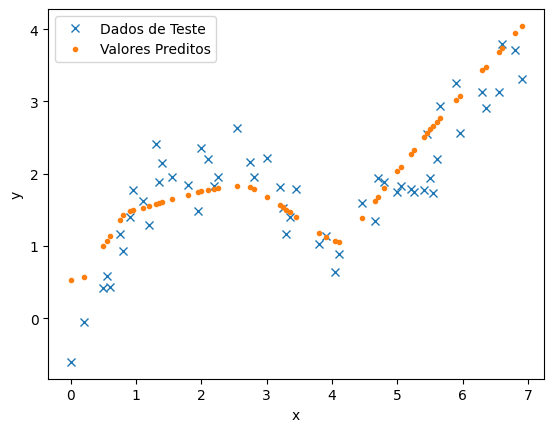

In [ ]:
plt.plot(x_test5, y_test5, 'x', label = 'Dados de Teste')
plt.plot(x_test5, predictions_test5, '.', label = 'Valores Preditos')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

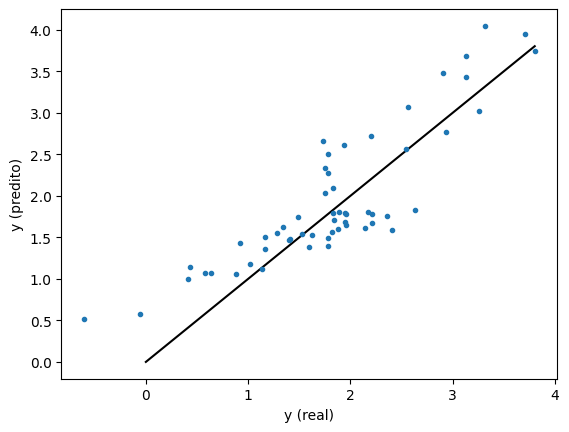

In [ ]:
plt.plot([0,torch.max(y_test5)], [0,torch.max(y_test5)], 'black')
plt.plot(y_test5, predictions_test5, '.')
plt.xlabel('y (real)')
plt.ylabel('y (predito)')
plt.show()

## Comparações entre Modelos

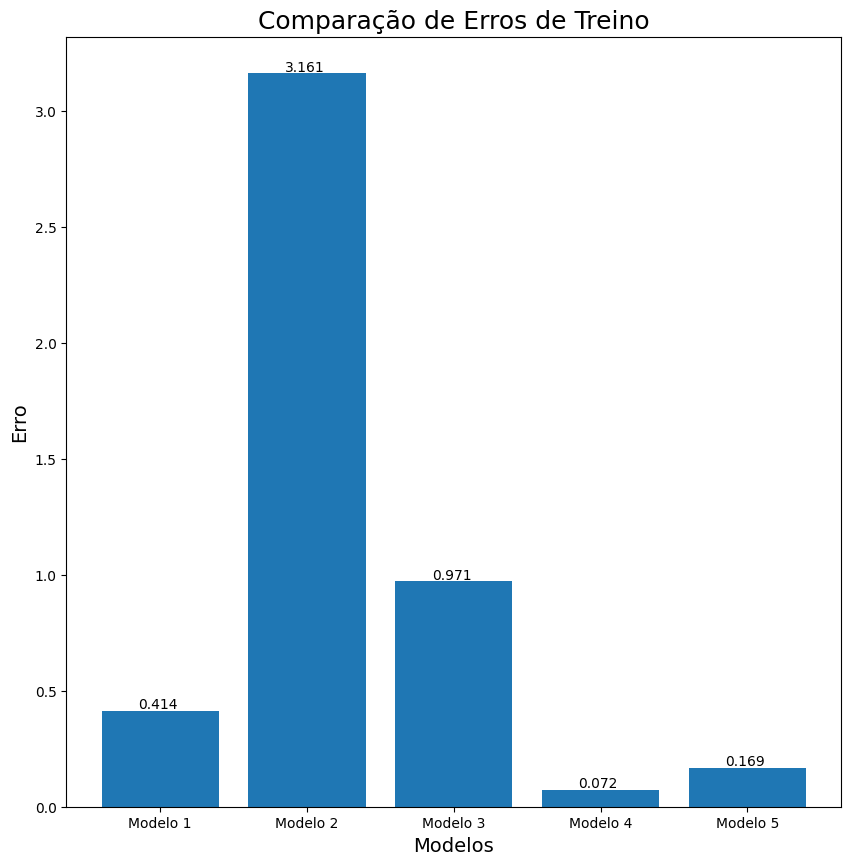

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [erro_train, erro_train2, erro_train3, erro_train4, erro_train5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Erros de Treino', fontsize = 18)
ax.set_ylabel('Erro', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.15
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

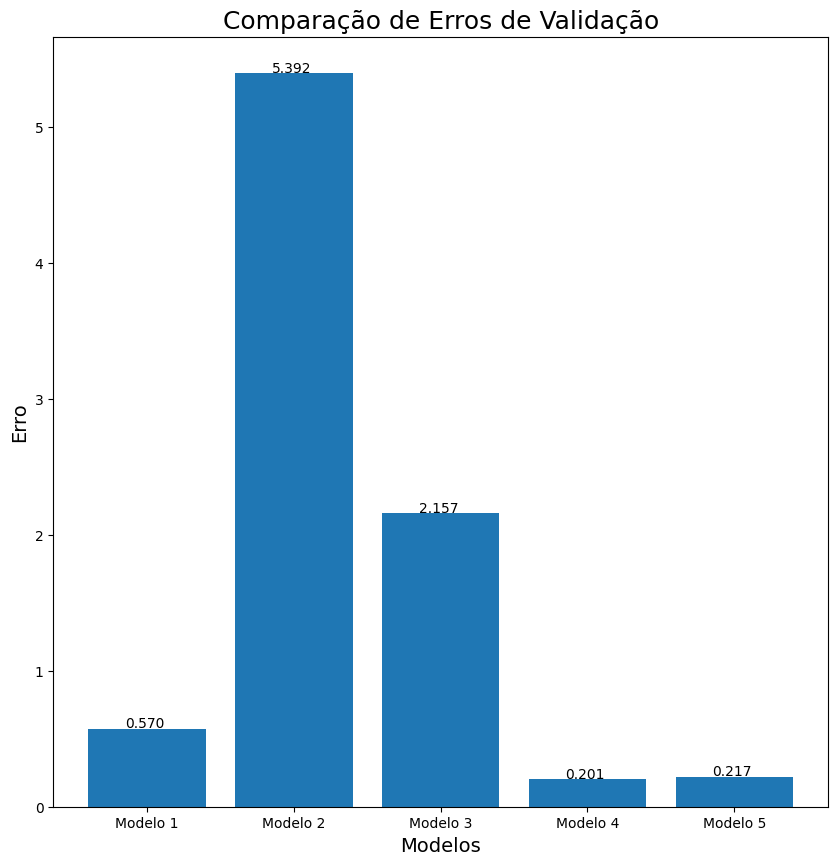

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [erro_val, erro_val2, erro_val3, erro_val4, erro_val5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Erros de Validação', fontsize = 18)
ax.set_ylabel('Erro', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.15
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

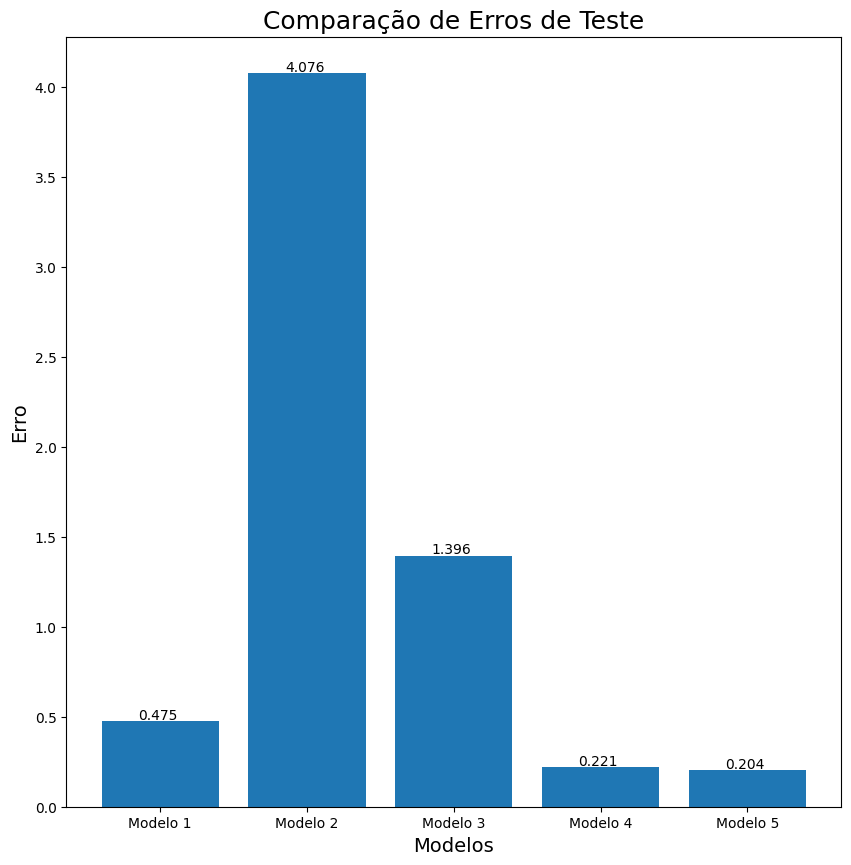

In [ ]:
labels = ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5']
values = [erro_test, erro_test2, erro_test3, erro_test4, erro_test5]

fig, ax = plt.subplots(figsize = (10, 10))
ax.bar(labels, values)

ax.set_title('Comparação de Erros de Teste', fontsize = 18)
ax.set_ylabel('Erro', fontsize = 14)
ax.set_xlabel('Modelos', fontsize = 14)

for idx, val in enumerate(values):
  txt = f'{val:.3f}'
  x_coord = idx - 0.15
  y_coord = val + 0.01
  ax.text(x = x_coord, y = y_coord, s = txt, fontsize = 10)

plt.show()

# Relatório

# Classificação
  <div style='text-align: justify;'>
  Primeiramente neste trabalho, foi realizada uma classificação utilizando uma rede MLP e o conjunto Íris para treino, um conjunto muito conhecido e bem feito, com 50 exemplos para cada um dos três tipos de plantas. Neste trabalho foram separados, dos 150 exemplos do conjunto, 90% para desenvolvimento e 10% para testes, e destes 90%, 80% foram para treino e 20% para validação totalizando:
    <ul>
      <li> 108 para treino da rede; </li>
      <li> 27 para validação; </li>
      <li> 15 para teste. </li>
    </ul>
  Para realizar os treinamentos foram implementados cinco modelos de MLP, sendo eles:
    <ol>
      <li> Modelo com duas camadas ocultas; </li>
      <li> Modelo com apenas uma camada; </li>
      <li> Modelo com quatro camadas ocultas e uso do momentum; </li>
      <li> Modelo com cinco camadas ocultas e uso de regularização L2; </li>
      <li> Modelo com três camadas ocultas. </li>
    </ol>

  Com os modelos treinados, é possível, então, avaliar os desempenhos que cada modelo obteve. Primeiramente é notável que a função de perda do modelo 4 foi a pior entre as todos os outros, mesmo com o uso de cinco camadas ocultas e a regularização L2, o que pode ser compreendido dado que o conjunto Iris é relativamente pequeno e simples, logo aplicar penalidades aos erros com a regularização L2 e até mesmo utilizar de cinco camadas ocultas para avaliar o mesmo não seja necessário e nem benéfico, pois o modelo pode ter aprendido tão bem o conjunto de treino, que não foi capaz de generalizar para a validação nem teste.

  Em contrapartida, o modelo 3 foi o melhor dos modelos utilizados, obteve a melhor acurácia em treino, validação e teste e seu erro de treino foi maior que seu erro de validação. Com isso é possível avaliar que utilizar do Momentum, para que a rede consiga convergir mais rápido, pode ser muito útil, ainda mais em um conjunto que não há muitas discrepâncias, o queo fez ser até melhor na validação do que no próprio treino.

  Contudo, os modelos 1 e 5 não ficaram muito para trás do modelo 4, ambos também obtiveram bons resultados, com acurácias de treino maiores que 96% e 98% respectivamente, sem o uso de Momentum ou de regularização e ambos também obtiveram erros de validação menores que erros de treino. Dessa forma, é possível notar que, para conjuntos simples, realmente redes mais simples podem resolver o problema de maneira eficaz e mais simplificada.

  Restando então apenas o modelo 2, utilizando apenas uma camada que não conseguiu obter resultados muito bons como os anteriores, mas ainda assim conseguiu se sobressair em relação ao modelo 4 e seu erro de validação foi maior que seu erro de treino.
  
  Com isso, pode-se concluir que para o conjunto Iris, utilizar de apenas uma camada pode sim se obter resultados com acurácias razoavelmente altas. Entretanto ao utilizar duas ou três camadas ocultas, os resultados obtidos são muito melhores, chegando à acurácias de treino, validação e teste que beiram todas as categorias ao 100%. É possível notar também que redes com mais complexidade, tendo mais de quatro camadas ocultas e ainda utilizando de regularizações, para um conjunto de dados simples, acaba por perder desempenho e capacidade de generalização. Portanto para o Iris, redes de até quatro camadas ocultas e o uso do momentum podem ser de grande utilidade, e trazem consigo uma boa capacidade de ajuste do modelo.
  </div>

# Regressão

  Para realizar a regressão foi utilizada uma função F(x), utilizando valores aleatórios de x, nos quais resultariam nos dados utilizados para se testar as regressões. No total foram 140 pontos, nos quais:

*   58 para treino;
*   26 para validação;
*   56 para teste.

  Dessa forma, para a realização das regressões foram utilizados cinco modelos de MLP, sendo eles:
1.  Modelo linear;
2.  Modelo com duas camadas;
3.  Modelo com três camadas;
4.  Modelo com cinco camadas;
5.  Modelo com oito camadas, regularização L2 e Momentum.

  Em uma primeira análise na comparação entre os modelos utilizados é possível perceber que o uso de dois ou três camadas não trouxe resultados interessantes, visto que obtiveram desempenhos não satisfatórios. Isso pode ter ocorrido por conta dos ruídos do conjunto gerado para treino, no qual mesmo com o uso de regularização L2 ou uso de Momentum ainda assim não conseguiu chegar a resultados que não fossem tão errôneos. Por outro lado uma rede mais simples possível como a linear, conseguiu chegar em números mais agradáveis, apesar de também não serem os melhores, alcançando um valor de 0.414 de erro de treino.

  Já os modelos 4 e modelo 5, com certa grau de robustez a mais, foram capazes de obter bons resultados ao ajustar a regressão e generalizar para o conjunto de teste. Ao utilizar cinco camadas, mesmo não havendo regularização ou uso de momentum, o modelo foi capaz de aprender uma curva na qual trouxe um erro de treino de apenas 0.072, de validação 0.201 e de teste 0.221, enquanto um modelo com mais camadas alcançou um erro de treino de 0.169, de validação 0.217, mas teve um leve ganho ao generalizar para o conjunto de teste, chegando a um erro de 0.204.

  Concluindo, é possível notar que ao terum conjunto de dados um pouco mais ruidosos, do que, por exemplo, o conjunto Iris, se mostraram melhores os conjuntos que possuem mais camadas e mais neurônios, todavia, que ainda assim evidenciaram que apenas ter muitas camadas ocultas ou neurônios disponíveis não siginifica que o resultado também será muito mais significativo.  

